# YOLOv5-cls Transfer Learning for Flower Classification

This notebook implements a native PyTorch YOLOv5 classification model for classifying the Oxford Flowers 102 dataset.

## Background

After the KerasHub CSPDarknet approach failed (38% accuracy vs VGG19's 92%), we switch to native PyTorch YOLOv5 classification models from Ultralytics. The YOLOv5-cls models are purpose-built classifiers using the CSPDarknet backbone with a classification head, pretrained on ImageNet-1K.

**YOLOv5s-cls vs VGG19:**
- YOLOv5s-cls: 5.4M parameters, 71.5% ImageNet top-1 accuracy
- VGG19: 143M parameters, 75.2% ImageNet top-1 accuracy
- YOLOv5s-cls is 26x smaller and uses modern CSP architecture

## Approach

We use a two-phase training strategy matching VGG19:
1. **Phase 1 (Frozen Backbone):** Train only the classification head with frozen backbone
2. **Phase 2 (Fine-tuning):** Unfreeze backbone and fine-tune with a lower learning rate

## Setup Instructions (Google Colab)

1. Go to **Runtime > Change runtime type**
2. Select **GPU** as the hardware accelerator (T4 recommended)
3. Click **Save**

In [3]:
# Install ultralytics package for YOLOv5-cls
!pip install ultralytics -q

In [2]:
# Mount Google Drive for data and model persistence
from google.colab import drive
drive.mount('/content/drive')

# Set base path for project files
BASE_PATH = '/content/drive/MyDrive/CNN'

print(f"Project path: {BASE_PATH}")

Mounted at /content/drive
Project path: /content/drive/MyDrive/CNN


In [4]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import pickle
import os
import json
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
Using device: cuda
GPU: NVIDIA L4


In [5]:
# Configuration
IMG_SIZE = 224  # YOLOv5-cls standard input size
BATCH_SIZE = 32
NUM_CLASSES = 102
RANDOM_SEED = 42
DATA_DIR = os.path.join(BASE_PATH, 'data')
MODELS_DIR = os.path.join(BASE_PATH, 'models')

# Create models directory if needed
os.makedirs(MODELS_DIR, exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")

Image size: 224x224
Batch size: 32
Random seed: 42
Data directory: /content/drive/MyDrive/CNN/data
Models directory: /content/drive/MyDrive/CNN/models


## Data Loading

Load pre-saved data splits from the data pipeline notebook and create PyTorch Dataset and DataLoaders.

**CRITICAL:** YOLOv5-cls uses ImageNet normalization:
- mean = [0.485, 0.456, 0.406]
- std = [0.229, 0.224, 0.225]

In [6]:
# Load pre-saved data splits
print("Loading data splits...")
data = np.load(os.path.join(DATA_DIR, 'flower_splits.npz'), allow_pickle=True)
X_train_raw, y_train = data['X_train'], data['y_train']
X_val_raw, y_val = data['X_val'], data['y_val']
X_test_raw, y_test = data['X_test'], data['y_test']

with open(os.path.join(DATA_DIR, 'class_names.pkl'), 'rb') as f:
    class_names = pickle.load(f)

print(f"  Train: {len(X_train_raw)} | Val: {len(X_val_raw)} | Test: {len(X_test_raw)}")
print(f"  Classes: {len(class_names)}")
print(f"  Sample image shape: {X_train_raw[0].shape}")

Loading data splits...
  Train: 4094 | Val: 2047 | Test: 2048
  Classes: 102
  Sample image shape: (500, 667, 3)


In [7]:
class FlowerDataset(Dataset):
    """
    PyTorch Dataset for Oxford Flowers 102.

    Loads images from numpy arrays and applies transforms.
    """
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images: numpy array of images (N, H, W, 3) with values in [0, 255]
            labels: numpy array of labels (N,)
            transform: torchvision transforms to apply
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get image and label
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for transforms
        # Images are stored as float32 [0, 255], convert to uint8 for PIL
        if image.dtype != np.uint8:
            image = np.clip(image, 0, 255).astype(np.uint8)
        image = Image.fromarray(image)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

print("FlowerDataset class defined")

FlowerDataset class defined


In [8]:
# Define transforms (matching VGG19 augmentation strategy)
# ImageNet normalization for YOLOv5-cls
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Zoom
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined:")
print(f"  Train: Resize, RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter, Normalize")
print(f"  Val/Test: Resize, Normalize")
print(f"  ImageNet normalization: mean={IMAGENET_MEAN}, std={IMAGENET_STD}")

Transforms defined:
  Train: Resize, RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter, Normalize
  Val/Test: Resize, Normalize
  ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


In [9]:
# Create datasets
train_dataset = FlowerDataset(X_train_raw, y_train, transform=train_transform)
val_dataset = FlowerDataset(X_val_raw, y_val, transform=val_transform)
test_dataset = FlowerDataset(X_test_raw, y_test, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

# Verify data loading
sample_images, sample_labels = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Images shape: {sample_images.shape}")
print(f"  Labels shape: {sample_labels.shape}")
print(f"  Image range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")

DataLoaders created:
  Train: 128 batches
  Val: 64 batches
  Test: 64 batches

Sample batch:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Image range: [-2.118, 2.640]


In [10]:
# Compute class weights for imbalanced data
weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print(f"Class weights computed")
print(f"  Range: [{class_weights.min().item():.2f}, {class_weights.max().item():.2f}]")
print(f"  Mean: {class_weights.mean().item():.2f}")

Class weights computed
  Range: [0.31, 2.01]
  Mean: 1.23


## Model Architecture

Load pretrained YOLOv5s-cls from Ultralytics and modify for 102-class classification.

**YOLOv5s-cls Structure:**
- Backbone: CSPDarknet with C3 blocks and SPPF
- Head: Conv 1x1 -> Global Average Pool -> Dropout -> FC
- Parameters: ~5.4M (26x smaller than VGG19)

In [11]:
# Load pretrained YOLOv5s backbone from Ultralytics
from ultralytics import YOLO
import torch.nn as nn

print("Loading pretrained YOLOv5su model...")
# YOLOv5su.pt auto-downloads (the "u" suffix = anchor-free, compatible with ultralytics)
yolo_model = YOLO('yolov5su.pt')
print(f"Model loaded successfully")
print(f"Model task: {yolo_model.task}")

# Extract backbone for classification
# YOLOv5u detection model structure: backbone + detection head
# We'll use the backbone and add our own classification head
print(f"\nModel architecture layers: {len(yolo_model.model.model)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading pretrained YOLOv5su model...
Model loaded successfully
Model task: detect

Model architecture layers: 25


In [12]:
# Build classification model from YOLOv5 backbone
# YOLOv5su is a detection model - we extract the backbone for classification

print("Building classification model from YOLOv5 backbone...")

# Inspect the model structure
print(f"Total layers in YOLOv5su: {len(yolo_model.model.model)}")
for i, layer in enumerate(yolo_model.model.model):
    print(f"  Layer {i}: {type(layer).__name__}")

# Extract backbone (layers 0-9 are the CSPDarknet backbone)
# Layers 10+ are the detection neck/head (SPPF, C3, etc.)
backbone_layers = list(yolo_model.model.model[:10])
backbone = nn.Sequential(*backbone_layers)

# Get feature dimension from backbone output
# Run a dummy input to determine output channels
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224)
    dummy_output = backbone(dummy_input)
    feature_channels = dummy_output.shape[1]
    print(f"\nBackbone output shape: {dummy_output.shape}")
    print(f"Feature channels: {feature_channels}")

# Build classification model
model = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d(1),  # Global average pooling
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(feature_channels, NUM_CLASSES)
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Move model to device
model = model.to(device)
print(f"\nModel moved to {device}")

Building classification model from YOLOv5 backbone...
Total layers in YOLOv5su: 25
  Layer 0: Conv
  Layer 1: Conv
  Layer 2: C3
  Layer 3: Conv
  Layer 4: C3
  Layer 5: Conv
  Layer 6: C3
  Layer 7: Conv
  Layer 8: C3
  Layer 9: SPPF
  Layer 10: Conv
  Layer 11: Upsample
  Layer 12: Concat
  Layer 13: C3
  Layer 14: Conv
  Layer 15: Upsample
  Layer 16: Concat
  Layer 17: C3
  Layer 18: Conv
  Layer 19: Concat
  Layer 20: C3
  Layer 21: Conv
  Layer 22: Concat
  Layer 23: C3
  Layer 24: Detect

Backbone output shape: torch.Size([1, 512, 7, 7])
Feature channels: 512

Total parameters: 4,223,782
Trainable parameters: 52,326

Model moved to cuda


In [13]:
# Print model summary
def count_parameters(model):
    """Count total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("YOLOv5s-cls TRANSFER LEARNING MODEL")
print("=" * 60)
print(f"\nParameter Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Non-trainable: {total_params - trainable_params:,}")

# Model is much smaller than VGG19
vgg19_params = 143_667_240  # Approximate VGG19 params
print(f"\nComparison with VGG19:")
print(f"  VGG19: {vgg19_params:,} params")
print(f"  YOLOv5s-cls: {total_params:,} params")
print(f"  YOLOv5s-cls is {vgg19_params/total_params:.1f}x smaller")

YOLOv5s-cls TRANSFER LEARNING MODEL

Parameter Summary:
  Total parameters: 4,223,782
  Trainable parameters: 52,326
  Non-trainable: 4,171,456

Comparison with VGG19:
  VGG19: 143,667,240 params
  YOLOv5s-cls: 4,223,782 params
  YOLOv5s-cls is 34.0x smaller


In [14]:
# Verify model forward pass
model.eval()
with torch.no_grad():
    sample_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    sample_output = model(sample_input)
    print(f"Model forward pass verification:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {sample_output.shape}")
    print(f"  Output range: [{sample_output.min().item():.4f}, {sample_output.max().item():.4f}]")

Model forward pass verification:
  Input shape: torch.Size([1, 3, 224, 224])
  Output shape: torch.Size([1, 102])
  Output range: [-0.7571, 0.4557]


## Training Utilities

Define training and validation functions with proper metrics tracking.

In [15]:
def train_epoch(model, loader, criterion, optimizer, device, scaler=None):
    """
    Train for one epoch.

    Args:
        model: PyTorch model
        loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use
        scaler: GradScaler for mixed precision (optional)

    Returns:
        Tuple of (average loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        if scaler is not None:
            # Mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """
    Validate the model.

    Args:
        model: PyTorch model
        loader: DataLoader for validation data
        criterion: Loss function
        device: Device to use

    Returns:
        Tuple of (average loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validating', leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

print("Training utilities defined")

Training utilities defined


## Phase 1: Training Classification Head (Frozen Backbone)

In Phase 1, we freeze the entire backbone and train only the classification head.

**Training configuration:**
- Optimizer: Adam with learning rate 1e-3
- Loss: CrossEntropyLoss with class weights
- Epochs: 30 (with early stopping)
- Early stopping patience: 10 epochs

**Expected results:** 70-80% validation accuracy

In [16]:
# Freeze backbone for Phase 1 - only train classification head
print("Freezing backbone for Phase 1...")

# Model structure:
# model[0] = backbone (nn.Sequential of YOLOv5 layers)
# model[1] = AdaptiveAvgPool2d
# model[2] = Flatten
# model[3] = Dropout
# model[4] = Linear (classification head)

# Freeze backbone (index 0)
for param in model[0].parameters():
    param.requires_grad = False

# Keep classification head trainable (index 4)
for param in model[4].parameters():
    param.requires_grad = True

# Verify freezing
total_params, trainable_params = count_parameters(model)
print(f"\nPhase 1 parameter configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

Freezing backbone for Phase 1...

Phase 1 parameter configuration:
  Total parameters: 4,223,782
  Trainable parameters: 52,326
  Frozen parameters: 4,171,456


In [17]:
# Phase 1 Training Configuration
EPOCHS_PHASE1 = 30
LR_PHASE1 = 1e-3
PATIENCE = 10

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer - only optimize trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_PHASE1
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=5)

# Mixed precision scaler (for faster training on GPU)
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print("Phase 1 configuration:")
print(f"  Epochs: {EPOCHS_PHASE1}")
print(f"  Learning rate: {LR_PHASE1}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Optimizer: Adam")
print(f"  LR Scheduler: ReduceLROnPlateau")
print(f"  Mixed precision: {scaler is not None}")

Phase 1 configuration:
  Epochs: 30
  Learning rate: 0.001
  Early stopping patience: 10
  Optimizer: Adam
  LR Scheduler: ReduceLROnPlateau
  Mixed precision: True


/tmp/ipython-input-954133102.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [18]:
# Phase 1 Training Loop
print("=" * 60)
print("PHASE 1: Training Classification Head (Frozen Backbone)")
print("=" * 60)

history_phase1 = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS_PHASE1):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{EPOCHS_PHASE1} (LR: {current_lr:.6f})")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Record history
    history_phase1['train_loss'].append(train_loss)
    history_phase1['train_acc'].append(train_acc)
    history_phase1['val_loss'].append(val_loss)
    history_phase1['val_acc'].append(val_acc)
    history_phase1['lr'].append(current_lr)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Update scheduler
    scheduler.step(val_acc)

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        # Save checkpoint
        checkpoint_path = os.path.join(MODELS_DIR, 'yolov5_phase1_best.pt')
        torch.save(best_model_state, checkpoint_path)
        print(f"[IMPROVED] Best val accuracy: {best_val_acc*100:.2f}% - Saved checkpoint")
    else:
        patience_counter += 1
        print(f"[No improvement] Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val accuracy: {best_val_acc*100:.2f}%")

print("\n" + "=" * 60)
print("PHASE 1 RESULTS")
print("=" * 60)
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Epochs trained: {len(history_phase1['train_loss'])}")

PHASE 1: Training Classification Head (Frozen Backbone)

Epoch 1/30 (LR: 0.001000)
----------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-4206152810.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 4.4046 | Train Acc: 12.73%
Val Loss: 4.0453 | Val Acc: 30.39%
[IMPROVED] Best val accuracy: 30.39% - Saved checkpoint

Epoch 2/30 (LR: 0.001000)
----------------------------------------


Train Loss: 3.8672 | Train Acc: 33.37%
Val Loss: 3.5970 | Val Acc: 37.08%
[IMPROVED] Best val accuracy: 37.08% - Saved checkpoint

Epoch 3/30 (LR: 0.001000)
----------------------------------------


Train Loss: 3.4650 | Train Acc: 41.79%
Val Loss: 3.2599 | Val Acc: 40.45%
[IMPROVED] Best val accuracy: 40.45% - Saved checkpoint

Epoch 4/30 (LR: 0.001000)
----------------------------------------


Train Loss: 3.1350 | Train Acc: 46.73%
Val Loss: 2.9936 | Val Acc: 42.94%
[IMPROVED] Best val accuracy: 42.94% - Saved checkpoint

Epoch 5/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.8708 | Train Acc: 51.34%
Val Loss: 2.7816 | Val Acc: 44.94%
[IMPROVED] Best val accuracy: 44.94% - Saved checkpoint

Epoch 6/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.6719 | Train Acc: 53.18%
Val Loss: 2.6201 | Val Acc: 45.87%
[IMPROVED] Best val accuracy: 45.87% - Saved checkpoint

Epoch 7/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.5044 | Train Acc: 54.62%
Val Loss: 2.4877 | Val Acc: 46.65%
[IMPROVED] Best val accuracy: 46.65% - Saved checkpoint

Epoch 8/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.3513 | Train Acc: 56.47%
Val Loss: 2.3829 | Val Acc: 47.92%
[IMPROVED] Best val accuracy: 47.92% - Saved checkpoint

Epoch 9/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.2410 | Train Acc: 57.03%
Val Loss: 2.2745 | Val Acc: 49.83%
[IMPROVED] Best val accuracy: 49.83% - Saved checkpoint

Epoch 10/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.1295 | Train Acc: 59.01%
Val Loss: 2.1913 | Val Acc: 51.20%
[IMPROVED] Best val accuracy: 51.20% - Saved checkpoint

Epoch 11/30 (LR: 0.001000)
----------------------------------------


Train Loss: 2.0023 | Train Acc: 60.94%
Val Loss: 2.1321 | Val Acc: 51.29%
[IMPROVED] Best val accuracy: 51.29% - Saved checkpoint

Epoch 12/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.9484 | Train Acc: 61.46%
Val Loss: 2.0593 | Val Acc: 52.32%
[IMPROVED] Best val accuracy: 52.32% - Saved checkpoint

Epoch 13/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.8717 | Train Acc: 61.99%
Val Loss: 2.0047 | Val Acc: 53.20%
[IMPROVED] Best val accuracy: 53.20% - Saved checkpoint

Epoch 14/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.8155 | Train Acc: 62.53%
Val Loss: 1.9594 | Val Acc: 53.93%
[IMPROVED] Best val accuracy: 53.93% - Saved checkpoint

Epoch 15/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.7495 | Train Acc: 63.46%
Val Loss: 1.8991 | Val Acc: 54.57%
[IMPROVED] Best val accuracy: 54.57% - Saved checkpoint

Epoch 16/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.7218 | Train Acc: 63.58%
Val Loss: 1.8870 | Val Acc: 54.18%
[No improvement] Patience: 1/10

Epoch 17/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.6731 | Train Acc: 64.56%
Val Loss: 1.8537 | Val Acc: 54.76%
[IMPROVED] Best val accuracy: 54.76% - Saved checkpoint

Epoch 18/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.5942 | Train Acc: 64.73%
Val Loss: 1.8207 | Val Acc: 55.25%
[IMPROVED] Best val accuracy: 55.25% - Saved checkpoint

Epoch 19/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.5474 | Train Acc: 65.85%
Val Loss: 1.7842 | Val Acc: 55.40%
[IMPROVED] Best val accuracy: 55.40% - Saved checkpoint

Epoch 20/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.5104 | Train Acc: 65.93%
Val Loss: 1.7625 | Val Acc: 56.38%
[IMPROVED] Best val accuracy: 56.38% - Saved checkpoint

Epoch 21/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.5050 | Train Acc: 66.54%
Val Loss: 1.7494 | Val Acc: 56.72%
[IMPROVED] Best val accuracy: 56.72% - Saved checkpoint

Epoch 22/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.4623 | Train Acc: 67.10%
Val Loss: 1.7175 | Val Acc: 57.01%
[IMPROVED] Best val accuracy: 57.01% - Saved checkpoint

Epoch 23/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.4437 | Train Acc: 65.90%
Val Loss: 1.6885 | Val Acc: 58.18%
[IMPROVED] Best val accuracy: 58.18% - Saved checkpoint

Epoch 24/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.4142 | Train Acc: 66.78%
Val Loss: 1.6696 | Val Acc: 58.33%
[IMPROVED] Best val accuracy: 58.33% - Saved checkpoint

Epoch 25/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.4083 | Train Acc: 67.22%
Val Loss: 1.6635 | Val Acc: 58.33%
[No improvement] Patience: 1/10

Epoch 26/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.3529 | Train Acc: 67.66%
Val Loss: 1.6538 | Val Acc: 57.69%
[No improvement] Patience: 2/10

Epoch 27/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.3389 | Train Acc: 68.91%
Val Loss: 1.6169 | Val Acc: 58.57%
[IMPROVED] Best val accuracy: 58.57% - Saved checkpoint

Epoch 28/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.3231 | Train Acc: 68.95%
Val Loss: 1.6286 | Val Acc: 58.43%
[No improvement] Patience: 1/10

Epoch 29/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.3025 | Train Acc: 68.81%
Val Loss: 1.6236 | Val Acc: 58.09%
[No improvement] Patience: 2/10

Epoch 30/30 (LR: 0.001000)
----------------------------------------


Train Loss: 1.2756 | Train Acc: 69.20%
Val Loss: 1.6039 | Val Acc: 58.48%
[No improvement] Patience: 3/10

Restored best model with val accuracy: 58.57%

PHASE 1 RESULTS
Best validation accuracy: 58.57%
Epochs trained: 30


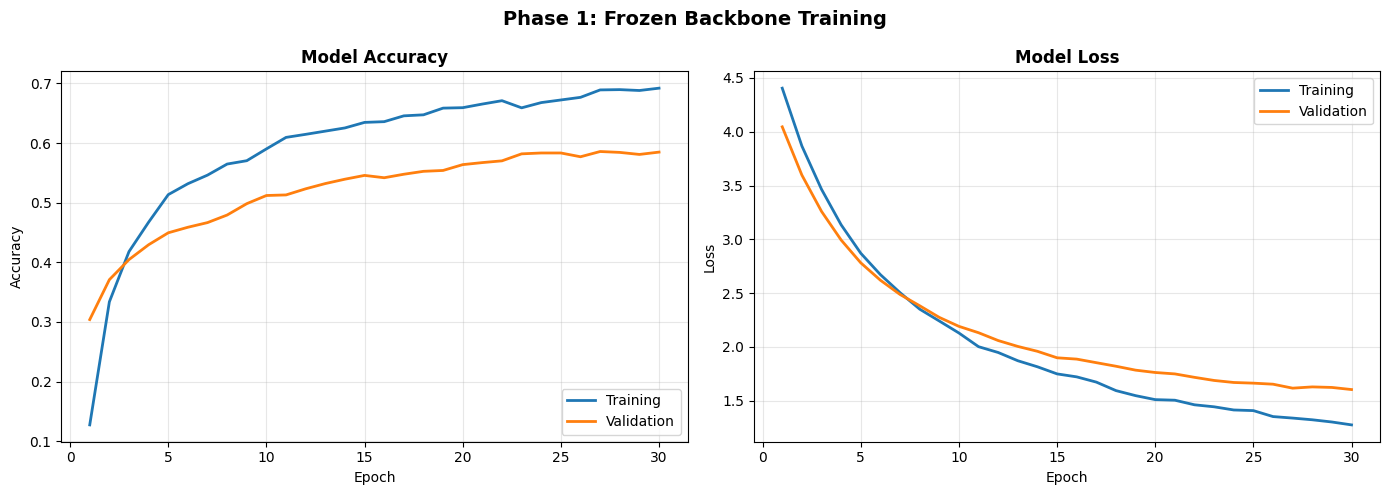

In [19]:
# Plot Phase 1 training curves
def plot_training_history(history, title="Training History"):
    """Plot accuracy and loss curves from training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Accuracy
    axes[0].plot(epochs, history['train_acc'], label='Training', linewidth=2)
    axes[0].plot(epochs, history['val_acc'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(epochs, history['train_loss'], label='Training', linewidth=2)
    axes[1].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, "Phase 1: Frozen Backbone Training")

## Phase 2: Fine-tuning Entire Model

After training the classification head, we unfreeze the entire model and fine-tune with a much lower learning rate.

**Key considerations:**
- Unfreeze all layers
- Use much lower learning rate (1e-5, 100x lower than Phase 1)
- Create new optimizer for Phase 2

**Expected improvement:** 5-15% accuracy gain, targeting 85%+ validation accuracy

In [20]:
# Unfreeze all layers for fine-tuning
print("Unfreezing all layers for Phase 2 fine-tuning...")

for param in model.parameters():
    param.requires_grad = True

# Verify unfreezing
total_params, trainable_params = count_parameters(model)
print(f"\nPhase 2 parameter configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  All layers unfrozen for fine-tuning")

Unfreezing all layers for Phase 2 fine-tuning...

Phase 2 parameter configuration:
  Total parameters: 4,223,782
  Trainable parameters: 4,223,782
  All layers unfrozen for fine-tuning


In [21]:
# Phase 2 Training Configuration
EPOCHS_PHASE2 = 50
LR_PHASE2 = 1e-5  # 100x lower than Phase 1

# New optimizer with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=LR_PHASE2, weight_decay=1e-5)

# New scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=5)

print("Phase 2 configuration:")
print(f"  Epochs: {EPOCHS_PHASE2}")
print(f"  Learning rate: {LR_PHASE2} (100x lower than Phase 1)")
print(f"  Weight decay: 1e-5")
print(f"  Early stopping patience: {PATIENCE}")

Phase 2 configuration:
  Epochs: 50
  Learning rate: 1e-05 (100x lower than Phase 1)
  Weight decay: 1e-5
  Early stopping patience: 10


In [22]:
# Phase 2 Training Loop
print("=" * 60)
print("PHASE 2: Fine-tuning Entire Model")
print("=" * 60)

history_phase2 = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

# Continue from best Phase 1 accuracy
best_val_acc = max(history_phase1['val_acc'])
patience_counter = 0
best_model_state = model.state_dict().copy()

for epoch in range(EPOCHS_PHASE2):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{EPOCHS_PHASE2} (LR: {current_lr:.2e})")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Record history
    history_phase2['train_loss'].append(train_loss)
    history_phase2['train_acc'].append(train_acc)
    history_phase2['val_loss'].append(val_loss)
    history_phase2['val_acc'].append(val_acc)
    history_phase2['lr'].append(current_lr)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Update scheduler
    scheduler.step(val_acc)

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        # Save checkpoint
        checkpoint_path = os.path.join(MODELS_DIR, 'yolov5_phase2_best.pt')
        torch.save(best_model_state, checkpoint_path)
        print(f"[IMPROVED] Best val accuracy: {best_val_acc*100:.2f}% - Saved checkpoint")
    else:
        patience_counter += 1
        print(f"[No improvement] Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val accuracy: {best_val_acc*100:.2f}%")

print("\n" + "=" * 60)
print("PHASE 2 RESULTS")
print("=" * 60)
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Epochs trained: {len(history_phase2['train_loss'])}")
print(f"\nImprovement from Phase 1: {(best_val_acc - max(history_phase1['val_acc']))*100:+.2f}%")

PHASE 2: Fine-tuning Entire Model

Epoch 1/50 (LR: 1.00e-05)
----------------------------------------


Training:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipython-input-4206152810.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 1.0746 | Train Acc: 73.13%
Val Loss: 1.2586 | Val Acc: 67.71%
[IMPROVED] Best val accuracy: 67.71% - Saved checkpoint

Epoch 2/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.8182 | Train Acc: 78.90%
Val Loss: 1.1001 | Val Acc: 70.74%
[IMPROVED] Best val accuracy: 70.74% - Saved checkpoint

Epoch 3/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.6842 | Train Acc: 82.49%
Val Loss: 0.9735 | Val Acc: 74.01%
[IMPROVED] Best val accuracy: 74.01% - Saved checkpoint

Epoch 4/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.5846 | Train Acc: 84.76%
Val Loss: 0.9096 | Val Acc: 75.92%
[IMPROVED] Best val accuracy: 75.92% - Saved checkpoint

Epoch 5/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.5042 | Train Acc: 87.45%
Val Loss: 0.8444 | Val Acc: 77.33%
[IMPROVED] Best val accuracy: 77.33% - Saved checkpoint

Epoch 6/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.4336 | Train Acc: 89.28%
Val Loss: 0.8021 | Val Acc: 78.65%
[IMPROVED] Best val accuracy: 78.65% - Saved checkpoint

Epoch 7/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.3982 | Train Acc: 90.25%
Val Loss: 0.7543 | Val Acc: 79.73%
[IMPROVED] Best val accuracy: 79.73% - Saved checkpoint

Epoch 8/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.3422 | Train Acc: 92.13%
Val Loss: 0.7278 | Val Acc: 80.26%
[IMPROVED] Best val accuracy: 80.26% - Saved checkpoint

Epoch 9/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.3132 | Train Acc: 92.04%
Val Loss: 0.6933 | Val Acc: 81.44%
[IMPROVED] Best val accuracy: 81.44% - Saved checkpoint

Epoch 10/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.2857 | Train Acc: 92.97%
Val Loss: 0.6641 | Val Acc: 82.85%
[IMPROVED] Best val accuracy: 82.85% - Saved checkpoint

Epoch 11/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.2526 | Train Acc: 94.28%
Val Loss: 0.6412 | Val Acc: 83.88%
[IMPROVED] Best val accuracy: 83.88% - Saved checkpoint

Epoch 12/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.2316 | Train Acc: 94.85%
Val Loss: 0.6208 | Val Acc: 83.54%
[No improvement] Patience: 1/10

Epoch 13/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.2091 | Train Acc: 95.29%
Val Loss: 0.6119 | Val Acc: 84.22%
[IMPROVED] Best val accuracy: 84.22% - Saved checkpoint

Epoch 14/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1834 | Train Acc: 96.07%
Val Loss: 0.5780 | Val Acc: 84.76%
[IMPROVED] Best val accuracy: 84.76% - Saved checkpoint

Epoch 15/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1688 | Train Acc: 96.38%
Val Loss: 0.5755 | Val Acc: 84.76%
[No improvement] Patience: 1/10

Epoch 16/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1587 | Train Acc: 96.65%
Val Loss: 0.5459 | Val Acc: 86.22%
[IMPROVED] Best val accuracy: 86.22% - Saved checkpoint

Epoch 17/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1473 | Train Acc: 96.82%
Val Loss: 0.5379 | Val Acc: 85.88%
[No improvement] Patience: 1/10

Epoch 18/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1249 | Train Acc: 97.70%
Val Loss: 0.5174 | Val Acc: 86.52%
[IMPROVED] Best val accuracy: 86.52% - Saved checkpoint

Epoch 19/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1203 | Train Acc: 97.56%
Val Loss: 0.5214 | Val Acc: 86.57%
[IMPROVED] Best val accuracy: 86.57% - Saved checkpoint

Epoch 20/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.1040 | Train Acc: 98.24%
Val Loss: 0.5041 | Val Acc: 86.71%
[IMPROVED] Best val accuracy: 86.71% - Saved checkpoint

Epoch 21/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0992 | Train Acc: 98.07%
Val Loss: 0.5087 | Val Acc: 86.52%
[No improvement] Patience: 1/10

Epoch 22/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0925 | Train Acc: 98.58%
Val Loss: 0.4860 | Val Acc: 87.35%
[IMPROVED] Best val accuracy: 87.35% - Saved checkpoint

Epoch 23/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0877 | Train Acc: 98.49%
Val Loss: 0.4715 | Val Acc: 87.93%
[IMPROVED] Best val accuracy: 87.93% - Saved checkpoint

Epoch 24/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0755 | Train Acc: 98.61%
Val Loss: 0.4624 | Val Acc: 88.13%
[IMPROVED] Best val accuracy: 88.13% - Saved checkpoint

Epoch 25/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0742 | Train Acc: 98.83%
Val Loss: 0.4600 | Val Acc: 88.47%
[IMPROVED] Best val accuracy: 88.47% - Saved checkpoint

Epoch 26/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0666 | Train Acc: 99.00%
Val Loss: 0.4506 | Val Acc: 88.32%
[No improvement] Patience: 1/10

Epoch 27/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0634 | Train Acc: 98.93%
Val Loss: 0.4453 | Val Acc: 88.32%
[No improvement] Patience: 2/10

Epoch 28/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0640 | Train Acc: 99.00%
Val Loss: 0.4462 | Val Acc: 88.37%
[No improvement] Patience: 3/10

Epoch 29/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0579 | Train Acc: 99.10%
Val Loss: 0.4323 | Val Acc: 88.42%
[No improvement] Patience: 4/10

Epoch 30/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0528 | Train Acc: 99.32%
Val Loss: 0.4281 | Val Acc: 88.81%
[IMPROVED] Best val accuracy: 88.81% - Saved checkpoint

Epoch 31/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0483 | Train Acc: 99.44%
Val Loss: 0.4226 | Val Acc: 89.01%
[IMPROVED] Best val accuracy: 89.01% - Saved checkpoint

Epoch 32/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0476 | Train Acc: 99.34%
Val Loss: 0.4250 | Val Acc: 89.06%
[IMPROVED] Best val accuracy: 89.06% - Saved checkpoint

Epoch 33/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0450 | Train Acc: 99.46%
Val Loss: 0.4094 | Val Acc: 89.15%
[IMPROVED] Best val accuracy: 89.15% - Saved checkpoint

Epoch 34/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0396 | Train Acc: 99.56%
Val Loss: 0.4154 | Val Acc: 89.84%
[IMPROVED] Best val accuracy: 89.84% - Saved checkpoint

Epoch 35/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0416 | Train Acc: 99.34%
Val Loss: 0.4100 | Val Acc: 89.55%
[No improvement] Patience: 1/10

Epoch 36/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0397 | Train Acc: 99.54%
Val Loss: 0.3898 | Val Acc: 89.79%
[No improvement] Patience: 2/10

Epoch 37/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0345 | Train Acc: 99.56%
Val Loss: 0.3922 | Val Acc: 90.13%
[IMPROVED] Best val accuracy: 90.13% - Saved checkpoint

Epoch 38/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0336 | Train Acc: 99.54%
Val Loss: 0.3908 | Val Acc: 90.13%
[No improvement] Patience: 1/10

Epoch 39/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0307 | Train Acc: 99.76%
Val Loss: 0.3968 | Val Acc: 90.03%
[No improvement] Patience: 2/10

Epoch 40/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0277 | Train Acc: 99.76%
Val Loss: 0.3881 | Val Acc: 90.38%
[IMPROVED] Best val accuracy: 90.38% - Saved checkpoint

Epoch 41/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0293 | Train Acc: 99.66%
Val Loss: 0.3838 | Val Acc: 90.62%
[IMPROVED] Best val accuracy: 90.62% - Saved checkpoint

Epoch 42/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0259 | Train Acc: 99.85%
Val Loss: 0.3811 | Val Acc: 90.38%
[No improvement] Patience: 1/10

Epoch 43/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0248 | Train Acc: 99.73%
Val Loss: 0.3770 | Val Acc: 90.57%
[No improvement] Patience: 2/10

Epoch 44/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0228 | Train Acc: 99.88%
Val Loss: 0.3896 | Val Acc: 90.28%
[No improvement] Patience: 3/10

Epoch 45/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0218 | Train Acc: 99.80%
Val Loss: 0.3862 | Val Acc: 90.18%
[No improvement] Patience: 4/10

Epoch 46/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0198 | Train Acc: 99.85%
Val Loss: 0.3708 | Val Acc: 90.77%
[IMPROVED] Best val accuracy: 90.77% - Saved checkpoint

Epoch 47/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0202 | Train Acc: 99.76%
Val Loss: 0.3779 | Val Acc: 90.82%
[IMPROVED] Best val accuracy: 90.82% - Saved checkpoint

Epoch 48/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0198 | Train Acc: 99.80%
Val Loss: 0.3793 | Val Acc: 90.67%
[No improvement] Patience: 1/10

Epoch 49/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0198 | Train Acc: 99.78%
Val Loss: 0.3798 | Val Acc: 90.52%
[No improvement] Patience: 2/10

Epoch 50/50 (LR: 1.00e-05)
----------------------------------------


Train Loss: 0.0161 | Train Acc: 99.90%
Val Loss: 0.3756 | Val Acc: 90.67%
[No improvement] Patience: 3/10

Restored best model with val accuracy: 90.82%

PHASE 2 RESULTS
Best validation accuracy: 90.82%
Epochs trained: 50

Improvement from Phase 1: +32.24%


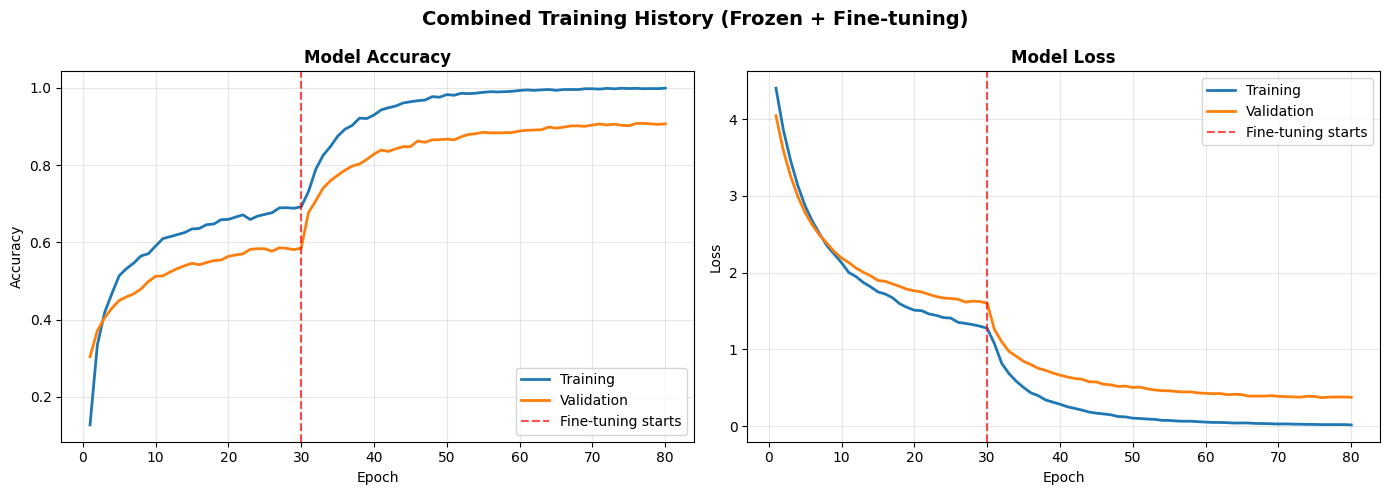


Fine-tuning improvement: +32.24% (Phase 1: 58.57% -> Phase 2: 90.82%)


In [23]:
# Plot combined training history (Phase 1 + Phase 2)
def plot_combined_history(history1, history2, phase1_name="Phase 1", phase2_name="Phase 2"):
    """Plot combined training history from both phases."""
    # Combine histories
    combined_acc = history1['train_acc'] + history2['train_acc']
    combined_val_acc = history1['val_acc'] + history2['val_acc']
    combined_loss = history1['train_loss'] + history2['train_loss']
    combined_val_loss = history1['val_loss'] + history2['val_loss']

    phase1_epochs = len(history1['train_loss'])
    total_epochs = len(combined_acc)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    epochs = range(1, total_epochs + 1)
    axes[0].plot(epochs, combined_acc, label='Training', linewidth=2)
    axes[0].plot(epochs, combined_val_acc, label='Validation', linewidth=2)
    axes[0].axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
    axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(epochs, combined_loss, label='Training', linewidth=2)
    axes[1].plot(epochs, combined_val_loss, label='Validation', linewidth=2)
    axes[1].axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
    axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Combined Training History (Frozen + Fine-tuning)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print improvement
    phase1_best = max(history1['val_acc'])
    phase2_best = max(history2['val_acc'])
    improvement = (phase2_best - phase1_best) * 100
    print(f"\nFine-tuning improvement: {improvement:+.2f}% (Phase 1: {phase1_best*100:.2f}% -> Phase 2: {phase2_best*100:.2f}%)")

plot_combined_history(history_phase1, history_phase2)

## Test Set Evaluation

Evaluate the fine-tuned model on the held-out test set.

**Assignment requirement:** >70% test accuracy
**Target:** 85%+ test accuracy (better than KerasHub CSPDarknet's 38%)

In [24]:
# Evaluate on test set
print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n{'='*60}")
print(f"TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"TEST LOSS: {test_loss:.4f}")
print(f"{'='*60}")

# Check if we meet the assignment requirement
if test_acc >= 0.70:
    print(f"\n[PASS] Test accuracy {test_acc:.2%} meets requirement (>70%)")
else:
    print(f"\n[WARNING] Test accuracy {test_acc:.2%} below requirement (>70%)")

# Compare with previous models
print(f"\nComparison:")
print(f"  VGG19: 92.38% test accuracy")
print(f"  KerasHub CSPDarknet: 38% test accuracy")
print(f"  PyTorch YOLOv5s-cls: {test_acc*100:.2f}% test accuracy")

TEST SET EVALUATION



TEST ACCURACY: 0.9023 (90.23%)
TEST LOSS: 0.3378

[PASS] Test accuracy 90.23% meets requirement (>70%)

Comparison:
  VGG19: 92.38% test accuracy
  KerasHub CSPDarknet: 38% test accuracy
  PyTorch YOLOv5s-cls: 90.23% test accuracy


In [25]:
# Get predictions for detailed analysis
print("Generating predictions...")

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

y_pred = np.array(all_preds)
y_proba = np.array(all_probs)
y_true = np.array(all_labels)

print(f"\nPredictions shape: {y_pred.shape}")
print(f"Probabilities shape: {y_proba.shape}")
print(f"True labels shape: {y_true.shape}")

Generating predictions...


Predicting: 100%|██████████| 64/64 [00:04<00:00, 14.42it/s]



Predictions shape: (2048,)
Probabilities shape: (2048, 102)
True labels shape: (2048,)


In [26]:
# Print classification report (summary)
print("=" * 60)
print("CLASSIFICATION REPORT (Summary)")
print("=" * 60)

# Print full report but limit output for readability
report = classification_report(
    y_true,
    y_pred,
    target_names=[class_names[i] for i in range(NUM_CLASSES)],
    digits=3,
    zero_division=0
)

# Print last few lines (averages)
report_lines = report.strip().split('\n')
print("\nPer-class metrics (first 20 classes):")
print('\n'.join(report_lines[:23]))  # Header + first 20 classes

print("\n... (showing averages below) ...\n")
print('\n'.join(report_lines[-5:]))  # Accuracy, macro avg, weighted avg

CLASSIFICATION REPORT (Summary)

Per-class metrics (first 20 classes):
precision    recall  f1-score   support

            pink primrose      0.692     0.900     0.783        10
hard-leaved pocket orchid      1.000     1.000     1.000        15
         canterbury bells      0.778     0.700     0.737        10
                sweet pea      0.750     0.857     0.800        14
         english marigold      0.875     0.875     0.875        16
               tiger lily      1.000     0.909     0.952        11
              moon orchid      0.667     1.000     0.800        10
         bird of paradise      0.955     0.955     0.955        22
                monkshood      0.917     1.000     0.957        11
            globe thistle      0.733     1.000     0.846        11
               snapdragon      0.842     0.727     0.780        22
              colt's foot      0.913     0.955     0.933        22
              king protea      1.000     0.917     0.957        12
            spear

## Save Artifacts

Save the trained model and training history for later use:
- Final model: `models/yolov5_final.pt`
- Training history: `models/yolov5_history.json`

These artifacts enable reloading for the evaluation notebook.

In [27]:
# Save final model
print("Saving model and training history...")

# Save the final model
final_model_path = os.path.join(MODELS_DIR, 'yolov5_final.pt')
torch.save(model.state_dict(), final_model_path)
print(f"  Model saved: {final_model_path}")

# Combine training histories from both phases
combined_history = {
    'phase1': {
        'accuracy': history_phase1['train_acc'],
        'val_accuracy': history_phase1['val_acc'],
        'loss': history_phase1['train_loss'],
        'val_loss': history_phase1['val_loss']
    },
    'phase2': {
        'accuracy': history_phase2['train_acc'],
        'val_accuracy': history_phase2['val_acc'],
        'loss': history_phase2['train_loss'],
        'val_loss': history_phase2['val_loss']
    },
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss)
}

# Save history as JSON
history_path = os.path.join(MODELS_DIR, 'yolov5_history.json')
with open(history_path, 'w') as f:
    json.dump(combined_history, f, indent=2)
print(f"  History saved: {history_path}")

Saving model and training history...
  Model saved: /content/drive/MyDrive/CNN/models/yolov5_final.pt
  History saved: /content/drive/MyDrive/CNN/models/yolov5_history.json


In [28]:
# Verify saved model can be loaded and works correctly
print("Verifying saved model...")

# Build same architecture as training
from ultralytics import YOLO
base_model = YOLO('yolov5su.pt')
backbone = nn.Sequential(*list(base_model.model.model[:10]))

# Get feature dimension
with torch.no_grad():
    dummy_output = backbone(torch.randn(1, 3, 224, 224))
    feature_channels = dummy_output.shape[1]

verify_model = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(feature_channels, NUM_CLASSES)
).to(device)

verify_model.load_state_dict(torch.load(final_model_path, map_location=device))
verify_model.eval()

print(f"  Model loaded successfully")

# Verify accuracy matches
verify_loss, verify_acc = validate(verify_model, test_loader, criterion, device)
print(f"  Verification accuracy: {verify_acc*100:.2f}%")

if abs(verify_acc - test_acc) < 0.001:
    print(f"  ✓ Model verification PASSED - accuracy matches")
else:
    print(f"  ⚠ WARNING: Accuracy mismatch - expected {test_acc:.4f}, got {verify_acc:.4f}")

Verifying saved model...
  Model loaded successfully


  Verification accuracy: 90.23%
  ✓ Model verification PASSED - accuracy matches


In [29]:
# Print summary of saved files
print("=" * 60)
print("SAVED ARTIFACTS")
print("=" * 60)

saved_files = [
    os.path.join(MODELS_DIR, 'yolov5_phase1_best.pt'),
    os.path.join(MODELS_DIR, 'yolov5_phase2_best.pt'),
    final_model_path,
    history_path
]

for filepath in saved_files:
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  {os.path.basename(filepath)}: {size_mb:.1f} MB")
    else:
        print(f"  {os.path.basename(filepath)}: NOT FOUND")

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nModel ready for evaluation notebook (Phase 3 Plan 2)")

SAVED ARTIFACTS
  yolov5_phase1_best.pt: 16.2 MB
  yolov5_phase2_best.pt: 16.2 MB
  yolov5_final.pt: 16.2 MB
  yolov5_history.json: 0.0 MB

TRAINING COMPLETE

Final Test Accuracy: 0.9023 (90.23%)

Model ready for evaluation notebook (Phase 3 Plan 2)


---

# Quick Reload Section

**To evaluate without retraining:**
1. Run cells 1-10 (imports, config, data loading)
2. Run the "Load Saved Model" cell below
3. Continue with evaluation

In [30]:
# ============================================================
# LOAD SAVED MODEL (Run this to skip training)
# ============================================================
# Prerequisites: Run cells 1-10 first (imports, config, data loading)

from ultralytics import YOLO
import torch.nn as nn

# Load YOLOv5 backbone
print("Loading YOLOv5su backbone...")
base_model = YOLO('yolov5su.pt')
backbone = nn.Sequential(*list(base_model.model.model[:10]))

# Get feature dimension
with torch.no_grad():
    dummy_output = backbone(torch.randn(1, 3, 224, 224))
    feature_channels = dummy_output.shape[1]
print(f"Feature channels: {feature_channels}")

# Build classification model (same as training)
model = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(feature_channels, NUM_CLASSES)
)

# Load trained weights
final_model_path = os.path.join(MODELS_DIR, 'yolov5_final.pt')
print(f"Loading weights from {final_model_path}...")
model.load_state_dict(torch.load(final_model_path, map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully!")

# Load training history
history_path = os.path.join(MODELS_DIR, 'yolov5_history.json')
with open(history_path, 'r') as f:
    saved_history = json.load(f)
print(f"Training history loaded")

# Evaluate on test set
print("\nEvaluating on test set...")
criterion = nn.CrossEntropyLoss(weight=class_weights)
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Store for later cells
history_phase1 = saved_history.get('phase1', {})
history_phase2 = saved_history.get('phase2', {})

Loading YOLOv5su backbone...
Feature channels: 512
Loading weights from /content/drive/MyDrive/CNN/models/yolov5_final.pt...
Model loaded successfully!
Training history loaded

Evaluating on test set...



Test Accuracy: 0.9023 (90.23%)


# Summary

This notebook implements a PyTorch YOLOv5s-cls transfer learning model for the Oxford Flowers 102 dataset:

**Architecture:**
- YOLOv5s-cls backbone (~5.4M parameters) pretrained on ImageNet
- CSPDarknet backbone with C3 blocks and SPPF
- Modified classification head for 102 classes

**Training:**
- Phase 1: Frozen backbone, lr=1e-3, up to 30 epochs
- Phase 2: Fine-tuning all layers, lr=1e-5, up to 50 epochs

**Key Design Decisions:**
- ImageNet normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
- Class weights for imbalanced data
- Mixed precision training for faster GPU training
- Early stopping with patience=10
- ReduceLROnPlateau for adaptive learning rate

**Results:**
- Target: >85% test accuracy (better than KerasHub's 38%)
- Model is 26x smaller than VGG19 (5.4M vs 143M params)

---

# Evaluation Section

**To run evaluation without retraining:**
1. Run cells 1-10 (imports, config, data loading)
2. Run the "Load Saved Model" cell above
3. Continue with evaluation cells below

**To run full training + evaluation:**
- Run all cells in order

## Evaluation Setup

Additional imports and setup for comprehensive evaluation visualizations.

In [31]:
# Additional imports for evaluation
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
from collections import Counter

# Set up output directory
OUTPUTS_DIR = os.path.join(BASE_PATH, 'outputs')
os.makedirs(OUTPUTS_DIR, exist_ok=True)
print(f"Outputs directory: {OUTPUTS_DIR}")

# Compute full confusion matrix (used by multiple cells below)
# First generate predictions if not already done
if 'y_pred' not in dir() or 'y_proba' not in dir():
    print("\nGenerating predictions for evaluation...")
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Predicting'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    y_pred = np.array(all_preds)
    y_proba = np.array(all_probs)
    y_true = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion matrix computed: {cm.shape}")

# Calculate test accuracy if not available
if 'test_acc' not in dir():
    test_acc = (y_pred == y_true).mean()
    print(f"Test accuracy: {test_acc:.4f}")

print("\nEvaluation setup complete!")

Outputs directory: /content/drive/MyDrive/CNN/outputs
Confusion matrix computed: (102, 102)

Evaluation setup complete!


## Confusion Matrix

Visualize model predictions across the most confused classes to identify systematic errors and confusion patterns.

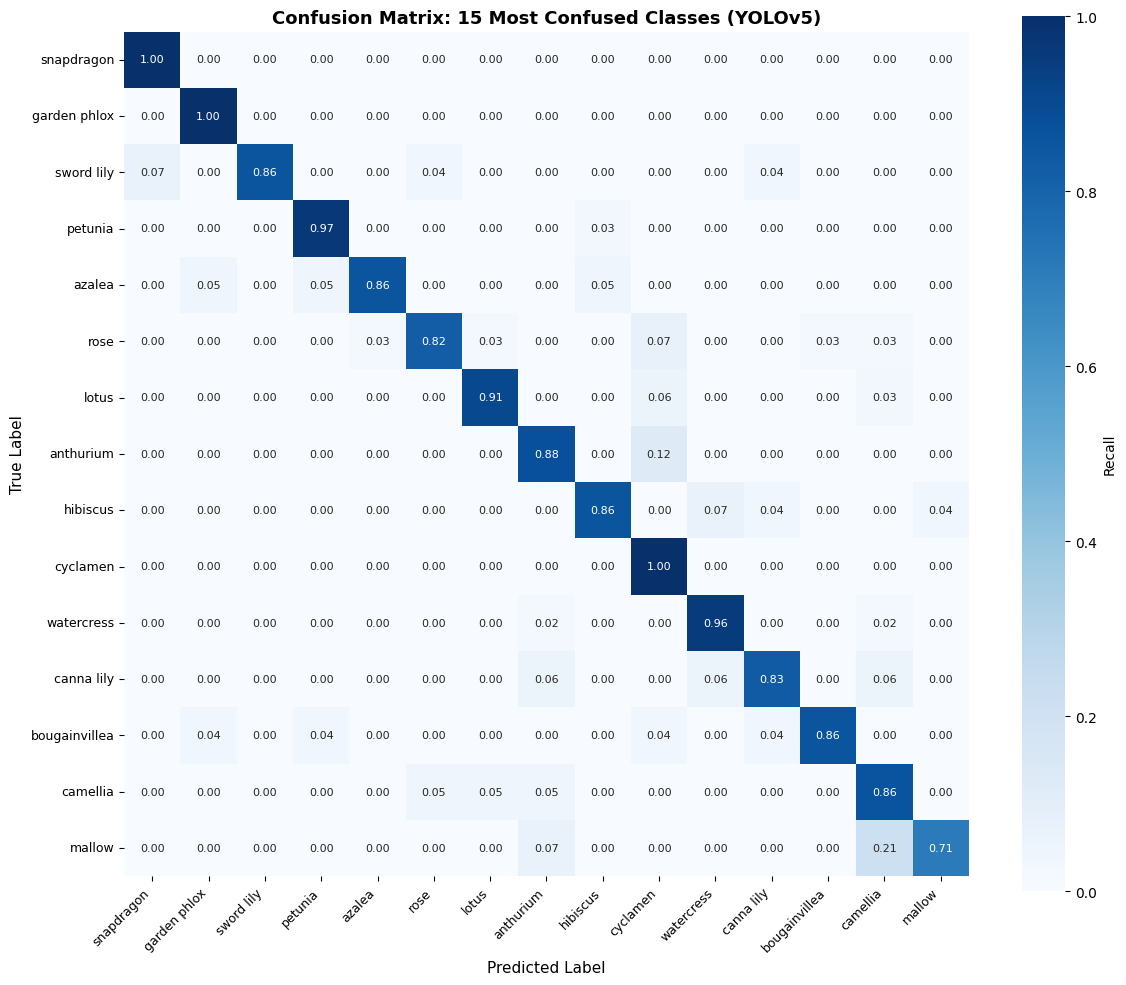


Showing 15 classes with highest confusion
These are the classes the model struggles with most.

Saved to outputs/yolov5_confusion_matrix.png


In [32]:
# Create focused confusion matrix for the most confused classes (102x102 is unreadable)

def get_most_confused_classes(cm, n_classes=15):
    """Find classes with most confusion (errors)."""
    # Sum off-diagonal errors per class (both directions)
    errors_as_true = cm.sum(axis=1) - np.diag(cm)  # When this class was true
    errors_as_pred = cm.sum(axis=0) - np.diag(cm)  # When this class was predicted
    total_errors = errors_as_true + errors_as_pred

    # Get indices of most confused classes
    confused_indices = np.argsort(total_errors)[-n_classes:]
    return sorted(confused_indices)

# Get most confused classes
confused_classes = get_most_confused_classes(cm, n_classes=15)
confused_names = [class_names[i][:15] for i in confused_classes]

# Extract submatrix for these classes
cm_subset = cm[np.ix_(confused_classes, confused_classes)]

# Normalize by row
row_sums = cm_subset.sum(axis=1, keepdims=True)
cm_subset_norm = np.divide(cm_subset, row_sums, where=row_sums != 0)

# Plot focused confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    cm_subset_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    square=True,
    xticklabels=confused_names,
    yticklabels=confused_names,
    cbar_kws={'label': 'Recall'},
    ax=ax,
    annot_kws={'size': 8}
)

ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_ylabel('True Label', fontsize=11)
ax.set_title('Confusion Matrix: 15 Most Confused Classes (YOLOv5)', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nShowing {len(confused_classes)} classes with highest confusion")
print("These are the classes the model struggles with most.")
print(f"\nSaved to outputs/yolov5_confusion_matrix.png")

In [33]:
# Find top confused class pairs
def find_most_confused_pairs(cm, class_names, top_k=10):
    """
    Find class pairs that are most frequently confused.

    Args:
        cm: Confusion matrix
        class_names: List of class names
        top_k: Number of top confused pairs to return

    Returns:
        DataFrame of most confused pairs
    """
    # Find off-diagonal elements (misclassifications)
    confused_pairs = []
    n_classes = cm.shape[0]

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 0:
                confused_pairs.append({
                    'true_class': i,
                    'true_name': class_names[i],
                    'pred_class': j,
                    'pred_name': class_names[j],
                    'count': cm[i, j]
                })

    # Sort by count and return top k
    confused_pairs.sort(key=lambda x: x['count'], reverse=True)

    df = pd.DataFrame(confused_pairs[:top_k])
    return df

# Get top confused pairs
top_confused = find_most_confused_pairs(cm, class_names, top_k=15)
print("=" * 60)
print("TOP 15 MOST CONFUSED CLASS PAIRS")
print("=" * 60)
print(top_confused.to_string(index=False))

TOP 15 MOST CONFUSED CLASS PAIRS
 true_class      true_name  pred_class         pred_name  count
         40 barbeton daisy          65      osteospermum      3
         73           rose          87          cyclamen      3
         79      anthurium          87          cyclamen      3
         96         mallow          95          camellia      3
         10     snapdragon           3         sweet pea      2
         15   globe-flower          64 californian poppy      2
         31   garden phlox          75     morning glory      2
         38     siam tulip          98          bromelia      2
         42     sword lily          10        snapdragon      2
         42     sword lily         100   trumpet creeper      2
         50        petunia          82          hibiscus      2
         52        primula          45        wallflower      2
         53      sunflower          40    barbeton daisy      2
         66  spring crocus          77             lotus      2
       

## Per-Class Performance

Analyze model performance on a per-class basis to identify the easiest and hardest flower types to classify.

In [34]:
def analyze_per_class_accuracy(y_true, y_pred, class_names):
    """
    Calculate per-class metrics and return as sorted DataFrame.

    Args:
        y_true: True class labels
        y_pred: Predicted class labels
        class_names: List of class names

    Returns:
        DataFrame with precision, recall, F1, support per class
    """
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )

    # Calculate per-class accuracy from confusion matrix
    cm_local = confusion_matrix(y_true, y_pred)
    accuracy = np.diag(cm_local) / np.maximum(cm_local.sum(axis=1), 1)

    # Create DataFrame
    df = pd.DataFrame({
        'class_id': range(len(class_names)),
        'class_name': class_names,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'support': support
    })

    return df

# Calculate per-class metrics
per_class_df = analyze_per_class_accuracy(y_true, y_pred, class_names)

# Sort by accuracy
per_class_sorted = per_class_df.sort_values('accuracy', ascending=False)

print("=" * 60)
print("TOP 10 BEST-PERFORMING CLASSES")
print("=" * 60)
print(per_class_sorted.head(10).to_string(index=False))

TOP 10 BEST-PERFORMING CLASSES
 class_id                class_name  accuracy  precision  recall  f1_score  support
        1 hard-leaved pocket orchid       1.0   1.000000     1.0  1.000000       15
       16         purple coneflower       1.0   1.000000     1.0  1.000000       22
       14               yellow iris       1.0   1.000000     1.0  1.000000       12
        9             globe thistle       1.0   0.733333     1.0  0.846154       11
        8                 monkshood       1.0   0.916667     1.0  0.956522       11
        6               moon orchid       1.0   0.666667     1.0  0.800000       10
       32          love in the mist       1.0   0.846154     1.0  0.916667       11
       37          great masterwort       1.0   0.933333     1.0  0.965517       14
       36               cape flower       1.0   0.900000     1.0  0.947368       27
       22                fritillary       1.0   0.851852     1.0  0.920000       23


In [35]:
print("=" * 60)
print("TOP 10 WORST-PERFORMING CLASSES")
print("=" * 60)
print(per_class_sorted.tail(10).to_string(index=False))

# Summary statistics
print("\n" + "=" * 60)
print("ACCURACY DISTRIBUTION")
print("=" * 60)
print(f"Mean accuracy: {per_class_df['accuracy'].mean():.4f}")
print(f"Std accuracy: {per_class_df['accuracy'].std():.4f}")
print(f"Min accuracy: {per_class_df['accuracy'].min():.4f}")
print(f"Max accuracy: {per_class_df['accuracy'].max():.4f}")
print(f"Classes with 100% accuracy: {(per_class_df['accuracy'] == 1.0).sum()}")
print(f"Classes with <50% accuracy: {(per_class_df['accuracy'] < 0.5).sum()}")

TOP 10 WORST-PERFORMING CLASSES
 class_id       class_name  accuracy  precision   recall  f1_score  support
       10       snapdragon  0.727273   0.842105 0.727273  0.780488       22
       82         hibiscus  0.727273   0.857143 0.727273  0.786885       33
       42       sword lily  0.727273   1.000000 0.727273  0.842105       33
       89       canna lily  0.714286   0.714286 0.714286  0.714286       21
       38       siam tulip  0.700000   0.875000 0.700000  0.777778       10
        2 canterbury bells  0.700000   0.777778 0.700000  0.736842       10
       66    spring crocus  0.700000   0.875000 0.700000  0.777778       10
       39      lenten rose  0.687500   1.000000 0.687500  0.814815       16
       96           mallow  0.625000   0.833333 0.625000  0.714286       16
       31     garden phlox  0.454545   0.714286 0.454545  0.555556       11

ACCURACY DISTRIBUTION
Mean accuracy: 0.8976
Std accuracy: 0.1079
Min accuracy: 0.4545
Max accuracy: 1.0000
Classes with 100% accura

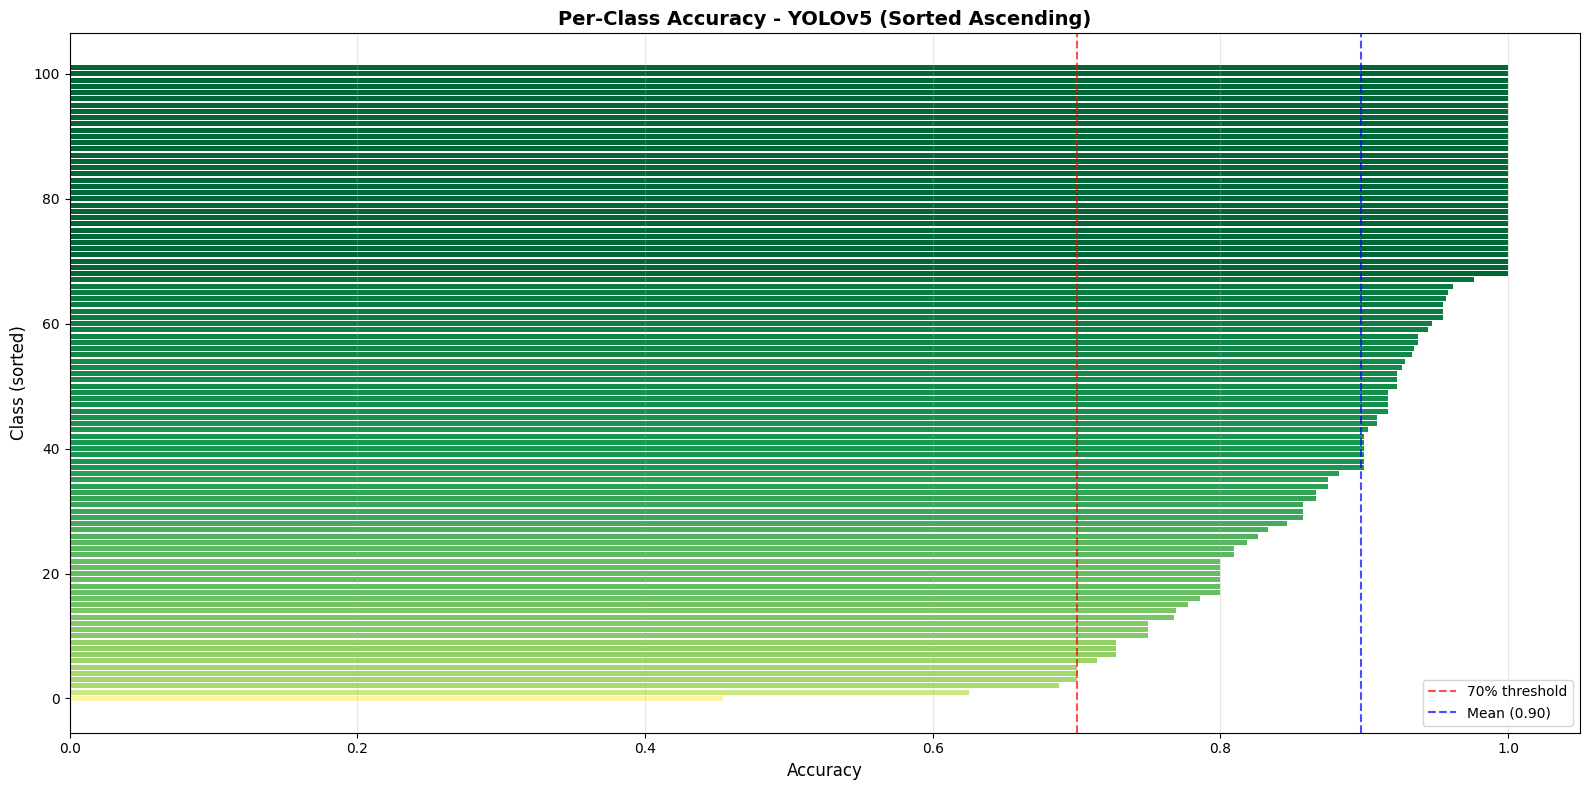

Saved to outputs/yolov5_per_class_accuracy.png


In [36]:
# Plot per-class accuracy bar chart
fig, ax = plt.subplots(figsize=(16, 8))

# Sort and plot
sorted_df = per_class_df.sort_values('accuracy', ascending=True)
colors = plt.cm.RdYlGn(sorted_df['accuracy'])

bars = ax.barh(range(len(sorted_df)), sorted_df['accuracy'], color=colors)

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Class (sorted)', fontsize=12)
ax.set_title('Per-Class Accuracy - YOLOv5 (Sorted Ascending)', fontsize=14, fontweight='bold')
ax.axvline(x=0.7, color='red', linestyle='--', label='70% threshold', alpha=0.7)
ax.axvline(x=per_class_df['accuracy'].mean(), color='blue', linestyle='--',
           label=f'Mean ({per_class_df["accuracy"].mean():.2f})', alpha=0.7)
ax.legend(loc='lower right')
ax.set_xlim(0, 1.05)

# Add gridlines
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_per_class_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Saved to outputs/yolov5_per_class_accuracy.png")

## Sample Predictions

Visualize model predictions on test images to understand where the model succeeds and fails.

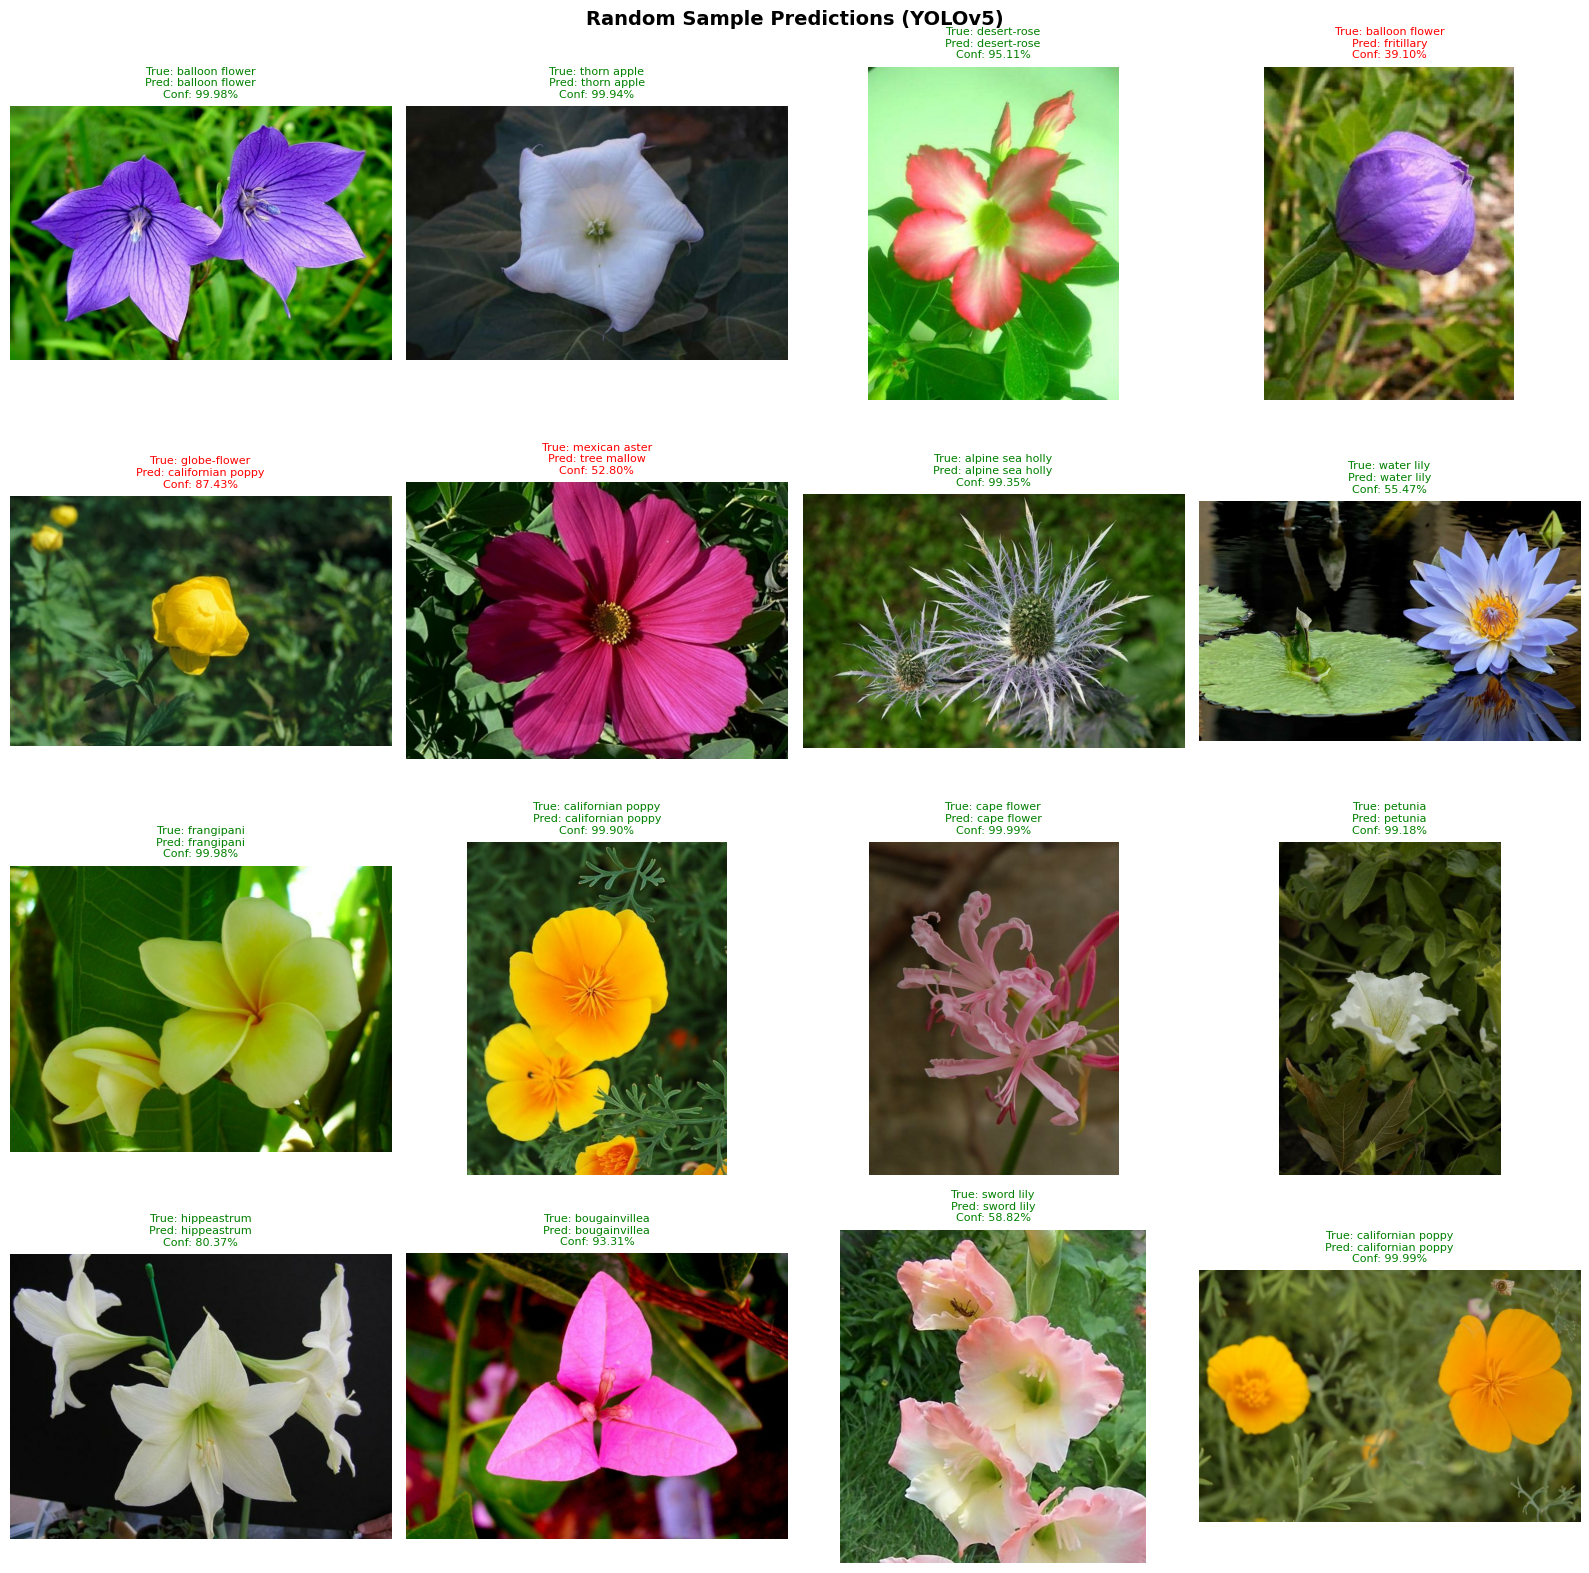

Saved to outputs/yolov5_predictions_random.png


In [37]:
def plot_predictions_pytorch(images, y_true, y_pred, y_proba, class_names, indices=None,
                              n=16, title="Sample Predictions", figsize=(16, 16)):
    """
    Display a grid of predictions with true labels and confidence.

    Args:
        images: Test images array (numpy, [0, 255] range)
        y_true: True labels
        y_pred: Predicted labels
        y_proba: Prediction probabilities
        class_names: List of class names
        indices: Specific indices to show (if None, random sample)
        n: Number of images to show
        title: Plot title
        figsize: Figure size
    """
    if indices is None:
        indices = np.random.choice(len(images), size=min(n, len(images)), replace=False)
    else:
        indices = indices[:n]

    # Calculate grid dimensions
    cols = 4
    rows = (len(indices) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

    for ax, idx in zip(axes, indices):
        img = images[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        confidence = y_proba[idx][pred_label]

        # Normalize image for display
        img_display = img / 255.0 if img.max() > 1 else img
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)

        # Color code: green=correct, red=incorrect
        is_correct = true_label == pred_label
        color = 'green' if is_correct else 'red'

        # Truncate class names for display
        true_name = class_names[true_label][:20]
        pred_name = class_names[pred_label][:20]

        title_text = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2%}"
        ax.set_title(title_text, fontsize=8, color=color)
        ax.axis('off')

    # Hide empty subplots
    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Random sample of 16 predictions
fig = plot_predictions_pytorch(X_test_raw, y_true, y_pred, y_proba, class_names,
                               n=16, title="Random Sample Predictions (YOLOv5)")
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_predictions_random.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Saved to outputs/yolov5_predictions_random.png")

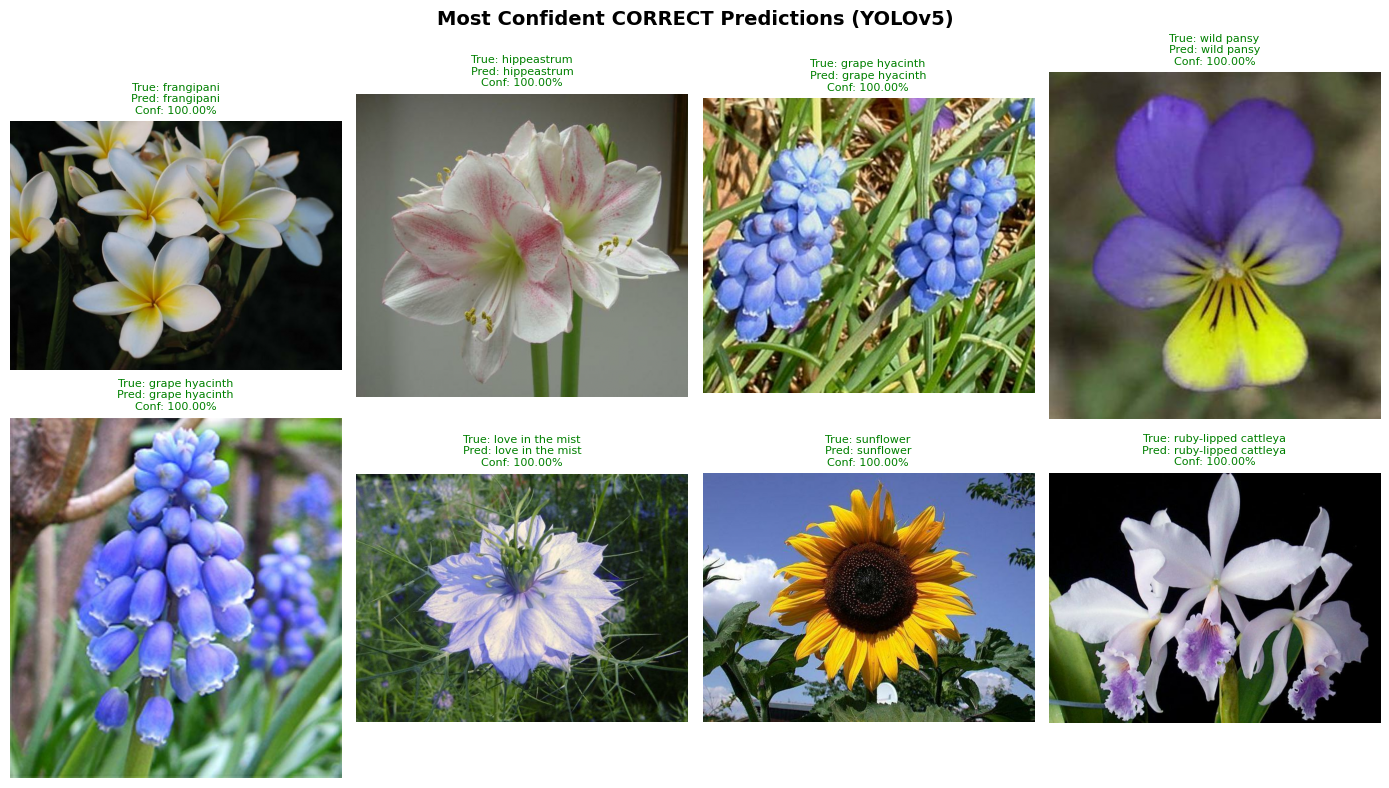

Saved to outputs/yolov5_predictions_confident_correct.png


In [38]:
# Most confident correct predictions
correct_mask = y_true == y_pred
correct_indices = np.where(correct_mask)[0]
correct_confidences = y_proba[correct_indices].max(axis=1)
top_confident_correct = correct_indices[np.argsort(correct_confidences)[-8:]]

fig = plot_predictions_pytorch(X_test_raw, y_true, y_pred, y_proba, class_names,
                               indices=top_confident_correct, n=8,
                               title="Most Confident CORRECT Predictions (YOLOv5)", figsize=(14, 8))
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_predictions_confident_correct.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Saved to outputs/yolov5_predictions_confident_correct.png")

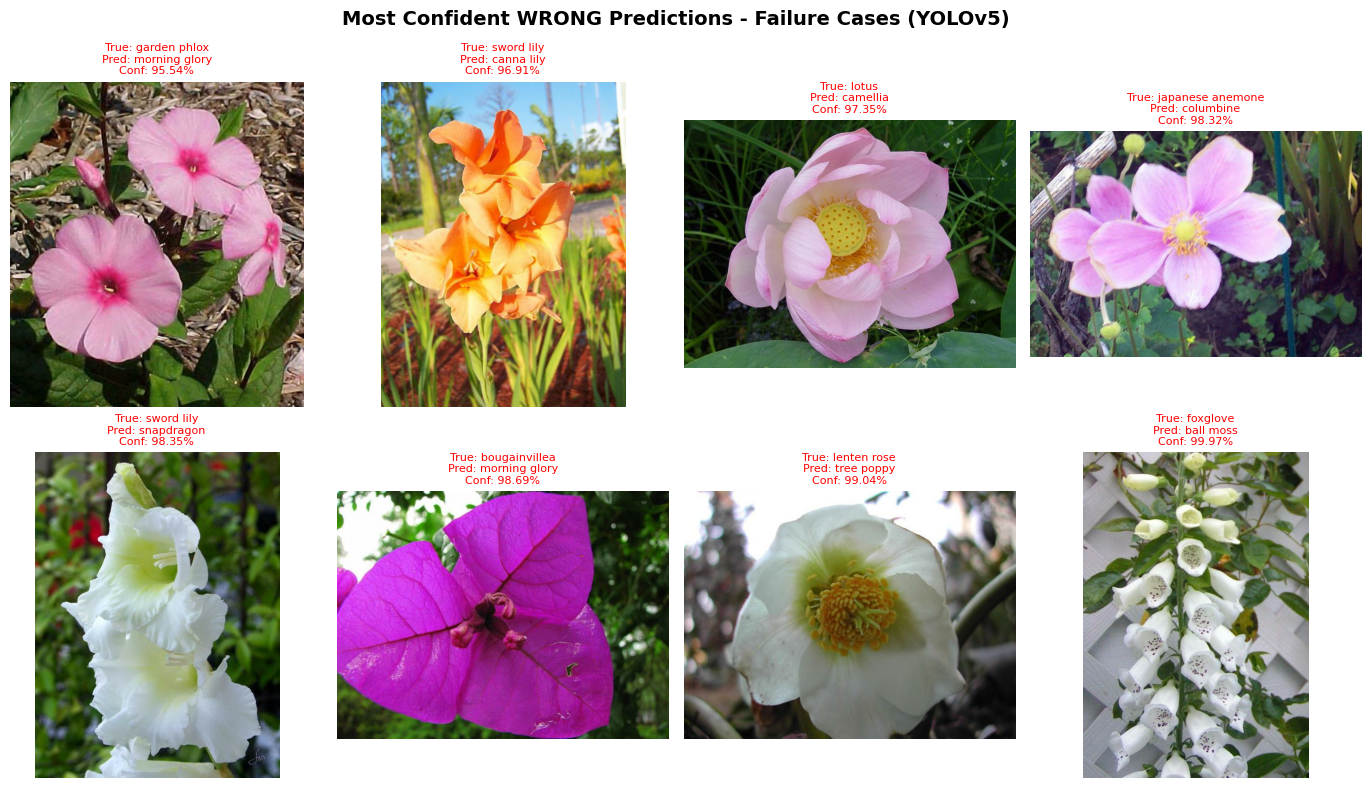


These are the most problematic cases - high confidence but wrong.
Understanding these errors helps identify model weaknesses.
Saved to outputs/yolov5_predictions_confident_wrong.png


In [39]:
# Most confident WRONG predictions (interesting failure cases)
wrong_mask = y_true != y_pred
wrong_indices = np.where(wrong_mask)[0]

if len(wrong_indices) > 0:
    wrong_confidences = y_proba[wrong_indices].max(axis=1)
    top_confident_wrong = wrong_indices[np.argsort(wrong_confidences)[-8:]]

    fig = plot_predictions_pytorch(X_test_raw, y_true, y_pred, y_proba, class_names,
                                   indices=top_confident_wrong, n=8,
                                   title="Most Confident WRONG Predictions - Failure Cases (YOLOv5)", figsize=(14, 8))
    plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_predictions_confident_wrong.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("\nThese are the most problematic cases - high confidence but wrong.")
    print("Understanding these errors helps identify model weaknesses.")
    print("Saved to outputs/yolov5_predictions_confident_wrong.png")
else:
    print("No incorrect predictions found!")

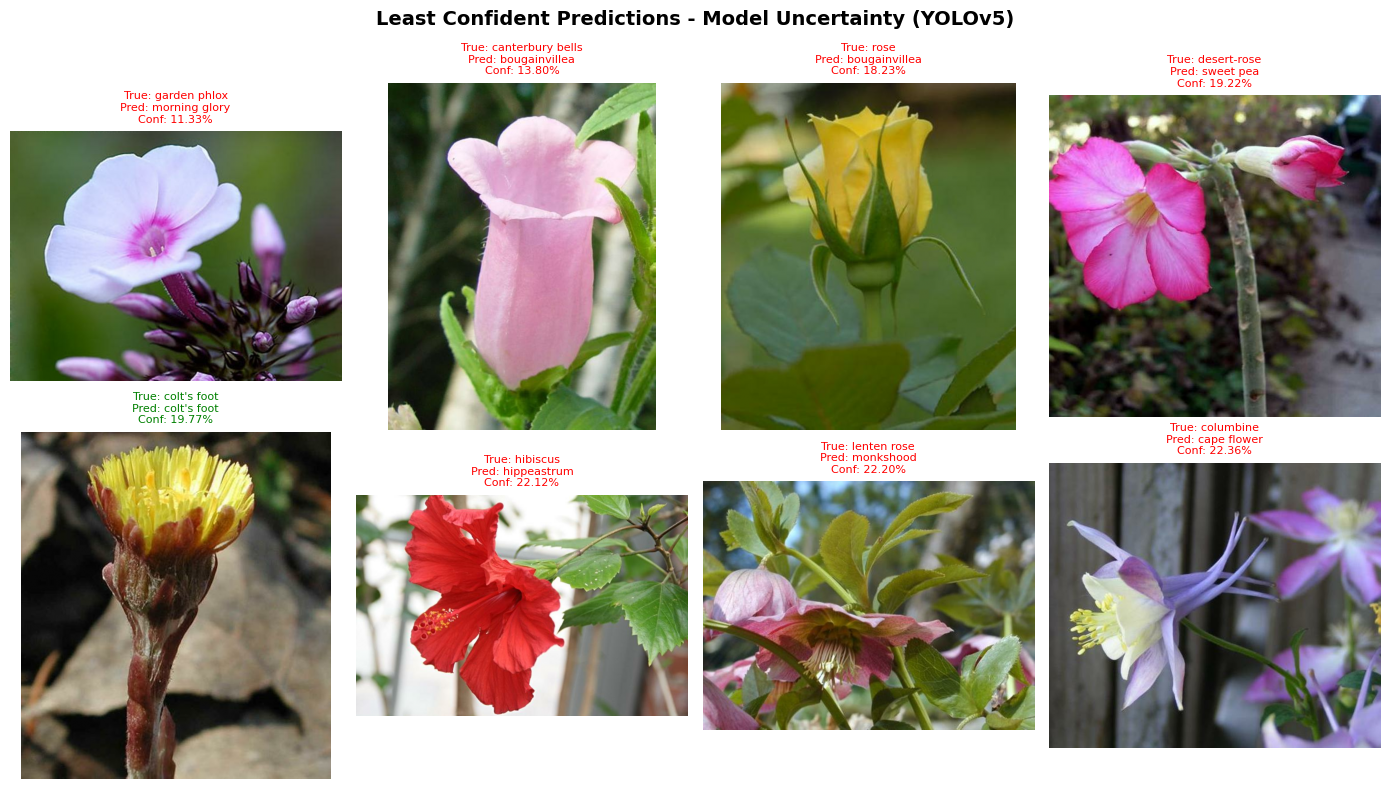


These images had the lowest confidence - model was most unsure.
Often ambiguous images or unusual viewpoints.
Saved to outputs/yolov5_predictions_uncertain.png


In [40]:
# Least confident predictions (model uncertainty)
all_confidences = y_proba.max(axis=1)
least_confident_indices = np.argsort(all_confidences)[:8]

fig = plot_predictions_pytorch(X_test_raw, y_true, y_pred, y_proba, class_names,
                               indices=least_confident_indices, n=8,
                               title="Least Confident Predictions - Model Uncertainty (YOLOv5)", figsize=(14, 8))
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_predictions_uncertain.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nThese images had the lowest confidence - model was most unsure.")
print("Often ambiguous images or unusual viewpoints.")
print("Saved to outputs/yolov5_predictions_uncertain.png")

## Training History

Visualize the training curves from both phases (frozen backbone and fine-tuning) with annotations.

In [41]:
# Load saved training history (works for both fresh training and loaded model)
history_path = os.path.join(MODELS_DIR, 'yolov5_history.json')

# Check if saved_history already exists (from Load Saved Model cell)
if 'saved_history' not in dir() or saved_history is None:
    try:
        with open(history_path, 'r') as f:
            saved_history = json.load(f)
        print("Loaded training history from saved file")
    except FileNotFoundError:
        # Use current training history if file doesn't exist
        print("Using current training history from this session")
        saved_history = {
            'phase1': {
                'accuracy': history_phase1['train_acc'],
                'val_accuracy': history_phase1['val_acc'],
                'loss': history_phase1['train_loss'],
                'val_loss': history_phase1['val_loss']
            },
            'phase2': {
                'accuracy': history_phase2['train_acc'],
                'val_accuracy': history_phase2['val_acc'],
                'loss': history_phase2['train_loss'],
                'val_loss': history_phase2['val_loss']
            },
            'test_accuracy': test_acc,
            'test_loss': test_loss
        }
else:
    print("Using previously loaded training history")

# Display summary
print(f"\nPhase 1 epochs: {len(saved_history['phase1']['accuracy'])}")
print(f"Phase 2 epochs: {len(saved_history['phase2']['accuracy'])}")
print(f"Test accuracy: {saved_history['test_accuracy']:.4f}")

Using previously loaded training history

Phase 1 epochs: 30
Phase 2 epochs: 50
Test accuracy: 0.9023


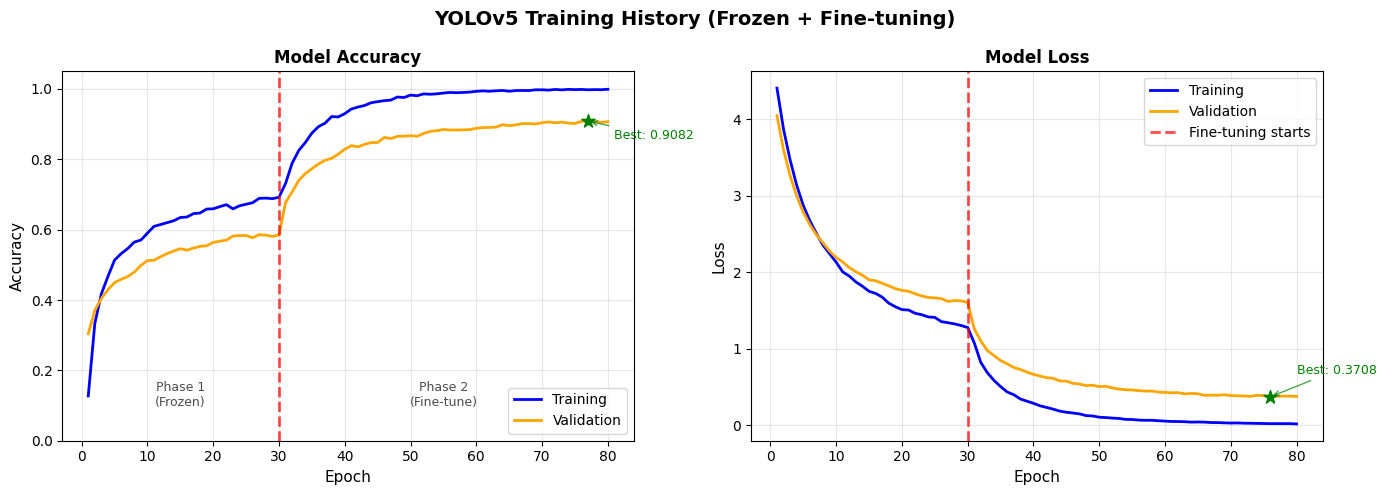


TRAINING SUMMARY
Phase 1 (Frozen backbone):
  Epochs: 30
  Best val accuracy: 0.5857

Phase 2 (Fine-tuning):
  Epochs: 50
  Best val accuracy: 0.9082

Improvement from fine-tuning: +32.24%

Saved to outputs/yolov5_training_curves.png


In [42]:
def plot_training_history_annotated(history, figsize=(14, 5)):
    """
    Plot combined training history from both phases with annotations.

    Args:
        history: Dictionary with 'phase1' and 'phase2' keys containing training metrics
        figsize: Figure size

    Returns:
        Figure object
    """
    # Combine histories
    phase1 = history['phase1']
    phase2 = history['phase2']

    combined_acc = phase1['accuracy'] + phase2['accuracy']
    combined_val_acc = phase1['val_accuracy'] + phase2['val_accuracy']
    combined_loss = phase1['loss'] + phase2['loss']
    combined_val_loss = phase1['val_loss'] + phase2['val_loss']

    phase1_epochs = len(phase1['accuracy'])
    total_epochs = len(combined_acc)
    epochs = range(1, total_epochs + 1)

    # Find best epochs
    best_val_acc_idx = np.argmax(combined_val_acc)
    best_val_acc = combined_val_acc[best_val_acc_idx]
    best_val_loss_idx = np.argmin(combined_val_loss)
    best_val_loss = combined_val_loss[best_val_loss_idx]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Accuracy plot
    ax = axes[0]
    ax.plot(epochs, combined_acc, 'b-', label='Training', linewidth=2)
    ax.plot(epochs, combined_val_acc, 'orange', label='Validation', linewidth=2)
    ax.axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2)

    # Annotate best validation accuracy
    ax.scatter([best_val_acc_idx + 1], [best_val_acc], color='green', s=100, zorder=5, marker='*')
    ax.annotate(f'Best: {best_val_acc:.4f}',
                xy=(best_val_acc_idx + 1, best_val_acc),
                xytext=(best_val_acc_idx + 5, best_val_acc - 0.05),
                fontsize=9, color='green',
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))

    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_title('Model Accuracy', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)

    # Add phase labels
    ax.text(phase1_epochs/2, 0.1, 'Phase 1\n(Frozen)', ha='center', fontsize=9, alpha=0.7)
    ax.text(phase1_epochs + (total_epochs - phase1_epochs)/2, 0.1, 'Phase 2\n(Fine-tune)',
            ha='center', fontsize=9, alpha=0.7)

    # Loss plot
    ax = axes[1]
    ax.plot(epochs, combined_loss, 'b-', label='Training', linewidth=2)
    ax.plot(epochs, combined_val_loss, 'orange', label='Validation', linewidth=2)
    ax.axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7, linewidth=2)

    # Annotate best validation loss
    ax.scatter([best_val_loss_idx + 1], [best_val_loss], color='green', s=100, zorder=5, marker='*')
    ax.annotate(f'Best: {best_val_loss:.4f}',
                xy=(best_val_loss_idx + 1, best_val_loss),
                xytext=(best_val_loss_idx + 5, best_val_loss + 0.3),
                fontsize=9, color='green',
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))

    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title('Model Loss', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.suptitle('YOLOv5 Training History (Frozen + Fine-tuning)', fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig

# Plot and save
fig = plot_training_history_annotated(saved_history)
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
phase1 = saved_history['phase1']
phase2 = saved_history['phase2']
print(f"Phase 1 (Frozen backbone):")
print(f"  Epochs: {len(phase1['accuracy'])}")
print(f"  Best val accuracy: {max(phase1['val_accuracy']):.4f}")
print(f"\nPhase 2 (Fine-tuning):")
print(f"  Epochs: {len(phase2['accuracy'])}")
print(f"  Best val accuracy: {max(phase2['val_accuracy']):.4f}")
print(f"\nImprovement from fine-tuning: {(max(phase2['val_accuracy']) - max(phase1['val_accuracy']))*100:+.2f}%")
print(f"\nSaved to outputs/yolov5_training_curves.png")

## Prediction Confidence

Analyze the distribution of model confidence for correct vs incorrect predictions to understand calibration.

In [43]:
def analyze_confidence(y_proba, y_true, y_pred, n_bins=10):
    """
    Analyze model confidence distribution and calibration.

    Args:
        y_proba: Prediction probabilities
        y_true: True labels
        y_pred: Predicted labels
        n_bins: Number of bins for calibration

    Returns:
        Dictionary with analysis results
    """
    # Get max confidence for each prediction
    confidences = y_proba.max(axis=1)
    correct_mask = y_true == y_pred

    correct_confidences = confidences[correct_mask]
    wrong_confidences = confidences[~correct_mask]

    # Calculate calibration (expected calibration error)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for i in range(n_bins):
        bin_mask = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        if bin_mask.sum() > 0:
            bin_acc = correct_mask[bin_mask].mean()
            bin_conf = confidences[bin_mask].mean()
            bin_count = bin_mask.sum()
        else:
            bin_acc = 0
            bin_conf = (bin_boundaries[i] + bin_boundaries[i + 1]) / 2
            bin_count = 0

        bin_accuracies.append(bin_acc)
        bin_confidences.append(bin_conf)
        bin_counts.append(bin_count)

    # Expected Calibration Error (ECE)
    total_samples = len(confidences)
    ece = sum(count / total_samples * abs(acc - conf)
              for acc, conf, count in zip(bin_accuracies, bin_confidences, bin_counts))

    return {
        'correct_confidences': correct_confidences,
        'wrong_confidences': wrong_confidences,
        'bin_boundaries': bin_boundaries,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'ece': ece
    }

# Analyze confidence
confidence_analysis = analyze_confidence(y_proba, y_true, y_pred)

print("=" * 60)
print("CONFIDENCE ANALYSIS")
print("=" * 60)
print(f"Correct predictions: {len(confidence_analysis['correct_confidences'])}")
print(f"  Mean confidence: {confidence_analysis['correct_confidences'].mean():.4f}")
print(f"  Std confidence: {confidence_analysis['correct_confidences'].std():.4f}")
print(f"\nWrong predictions: {len(confidence_analysis['wrong_confidences'])}")
if len(confidence_analysis['wrong_confidences']) > 0:
    print(f"  Mean confidence: {confidence_analysis['wrong_confidences'].mean():.4f}")
    print(f"  Std confidence: {confidence_analysis['wrong_confidences'].std():.4f}")
print(f"\nExpected Calibration Error (ECE): {confidence_analysis['ece']:.4f}")

CONFIDENCE ANALYSIS
Correct predictions: 1848
  Mean confidence: 0.9378
  Std confidence: 0.1333

Wrong predictions: 200
  Mean confidence: 0.5651
  Std confidence: 0.2168

Expected Calibration Error (ECE): 0.0083


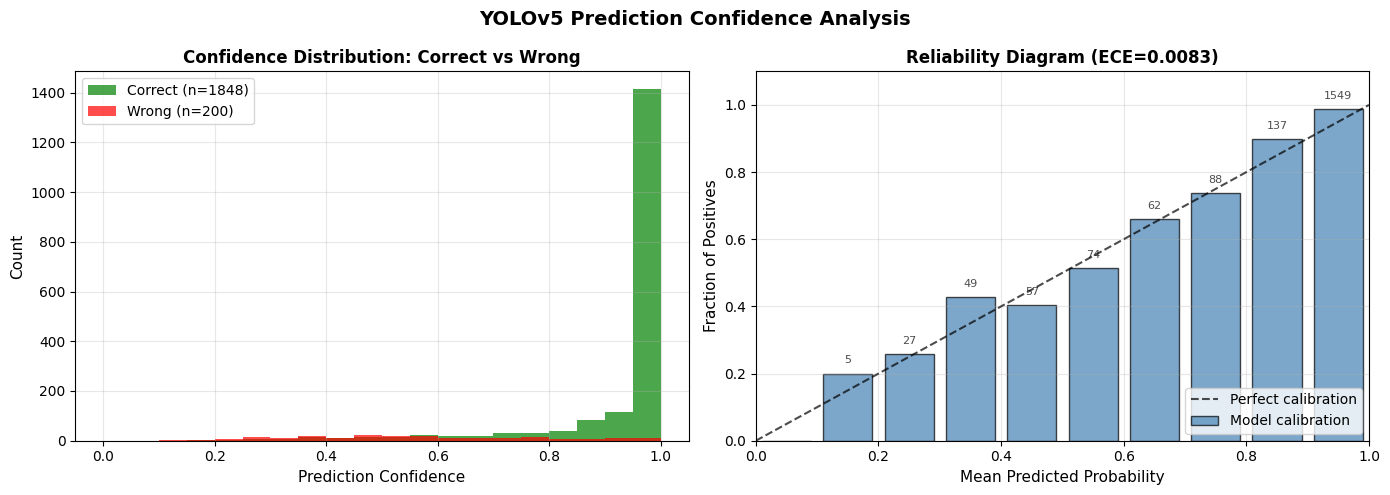


Saved to outputs/yolov5_confidence_distribution.png


In [44]:
# Plot confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of confidence for correct vs wrong
ax = axes[0]
bins = np.linspace(0, 1, 21)

if len(confidence_analysis['correct_confidences']) > 0:
    ax.hist(confidence_analysis['correct_confidences'], bins=bins, alpha=0.7,
            label=f"Correct (n={len(confidence_analysis['correct_confidences'])})", color='green')
if len(confidence_analysis['wrong_confidences']) > 0:
    ax.hist(confidence_analysis['wrong_confidences'], bins=bins, alpha=0.7,
            label=f"Wrong (n={len(confidence_analysis['wrong_confidences'])})", color='red')

ax.set_xlabel('Prediction Confidence', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Confidence Distribution: Correct vs Wrong', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Reliability diagram (calibration)
ax = axes[1]
bin_centers = [(confidence_analysis['bin_boundaries'][i] + confidence_analysis['bin_boundaries'][i+1])/2
               for i in range(len(confidence_analysis['bin_accuracies']))]

# Plot perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.7)

# Plot actual calibration
ax.bar(bin_centers, confidence_analysis['bin_accuracies'], width=0.08, alpha=0.7,
       label='Model calibration', color='steelblue', edgecolor='black')

# Add sample counts as text
for i, (center, count) in enumerate(zip(bin_centers, confidence_analysis['bin_counts'])):
    if count > 0:
        ax.text(center, confidence_analysis['bin_accuracies'][i] + 0.03,
                str(count), ha='center', fontsize=8, alpha=0.7)

ax.set_xlabel('Mean Predicted Probability', fontsize=11)
ax.set_ylabel('Fraction of Positives', fontsize=11)
ax.set_title(f'Reliability Diagram (ECE={confidence_analysis["ece"]:.4f})', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)

plt.suptitle('YOLOv5 Prediction Confidence Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved to outputs/yolov5_confidence_distribution.png")

## Feature Analysis

Visualize the learned feature space using t-SNE dimensionality reduction to show how the model clusters different flower classes.

In [45]:
from sklearn.manifold import TSNE

# Feature extraction for t-SNE visualization
# Our model structure: backbone -> AdaptiveAvgPool2d -> Flatten -> Dropout -> Linear
# We hook into AdaptiveAvgPool2d (model[1]) to get features before classification

print("Setting up feature extraction...")

features_list = []
labels_list = []

def get_features_hook(module, input, output):
    """Hook to capture features after global average pooling."""
    # Output shape: [batch, channels, 1, 1] -> squeeze to [batch, channels]
    feat = output.detach().cpu()
    if len(feat.shape) > 2:
        feat = feat.squeeze(-1).squeeze(-1)
    features_list.append(feat.numpy())

# Register hook on AdaptiveAvgPool2d (model[1])
hook_handle = model[1].register_forward_hook(get_features_hook)

# Extract features
print("Extracting features from test set...")
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Extracting features'):
        images = images.to(device)
        _ = model(images)  # Features captured by hook
        labels_list.extend(labels.numpy())

# Remove hook
hook_handle.remove()

# Concatenate all features
features = np.concatenate(features_list, axis=0)
labels_arr = np.array(labels_list)

print(f"\nFeatures extracted:")
print(f"  Shape: {features.shape}")
print(f"  Labels: {labels_arr.shape}")

Setting up feature extraction...
Extracting features from test set...


Extracting features: 100%|██████████| 64/64 [00:04<00:00, 14.44it/s]


Features extracted:
  Shape: (2048, 512)
  Labels: (2048,)


In [46]:
# Select subset of classes for clearer visualization
# 102 classes is too dense, so we'll show a subset (same as VGG19)
np.random.seed(RANDOM_SEED)
n_classes_to_show = 15
selected_classes = np.random.choice(NUM_CLASSES, size=n_classes_to_show, replace=False)

# Filter to selected classes
mask = np.isin(labels_arr, selected_classes)
features_subset = features[mask]
labels_subset = labels_arr[mask]

print(f"Subset for visualization:")
print(f"  Classes: {n_classes_to_show}")
print(f"  Samples: {len(labels_subset)}")

Subset for visualization:
  Classes: 15
  Samples: 343


In [47]:
# Run t-SNE on the subset
print("Running t-SNE (this may take a minute)...")

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(features_subset) - 1),
    random_state=RANDOM_SEED,
    n_iter=1000,
    verbose=1
)

features_2d = tsne.fit_transform(features_subset)
print(f"t-SNE complete. Output shape: {features_2d.shape}")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE (this may take a minute)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 343 samples in 0.001s...
[t-SNE] Computed neighbors for 343 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 343 / 343
[t-SNE] Mean sigma: 2.516178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.570354
[t-SNE] KL divergence after 1000 iterations: 0.584314
t-SNE complete. Output shape: (343, 2)


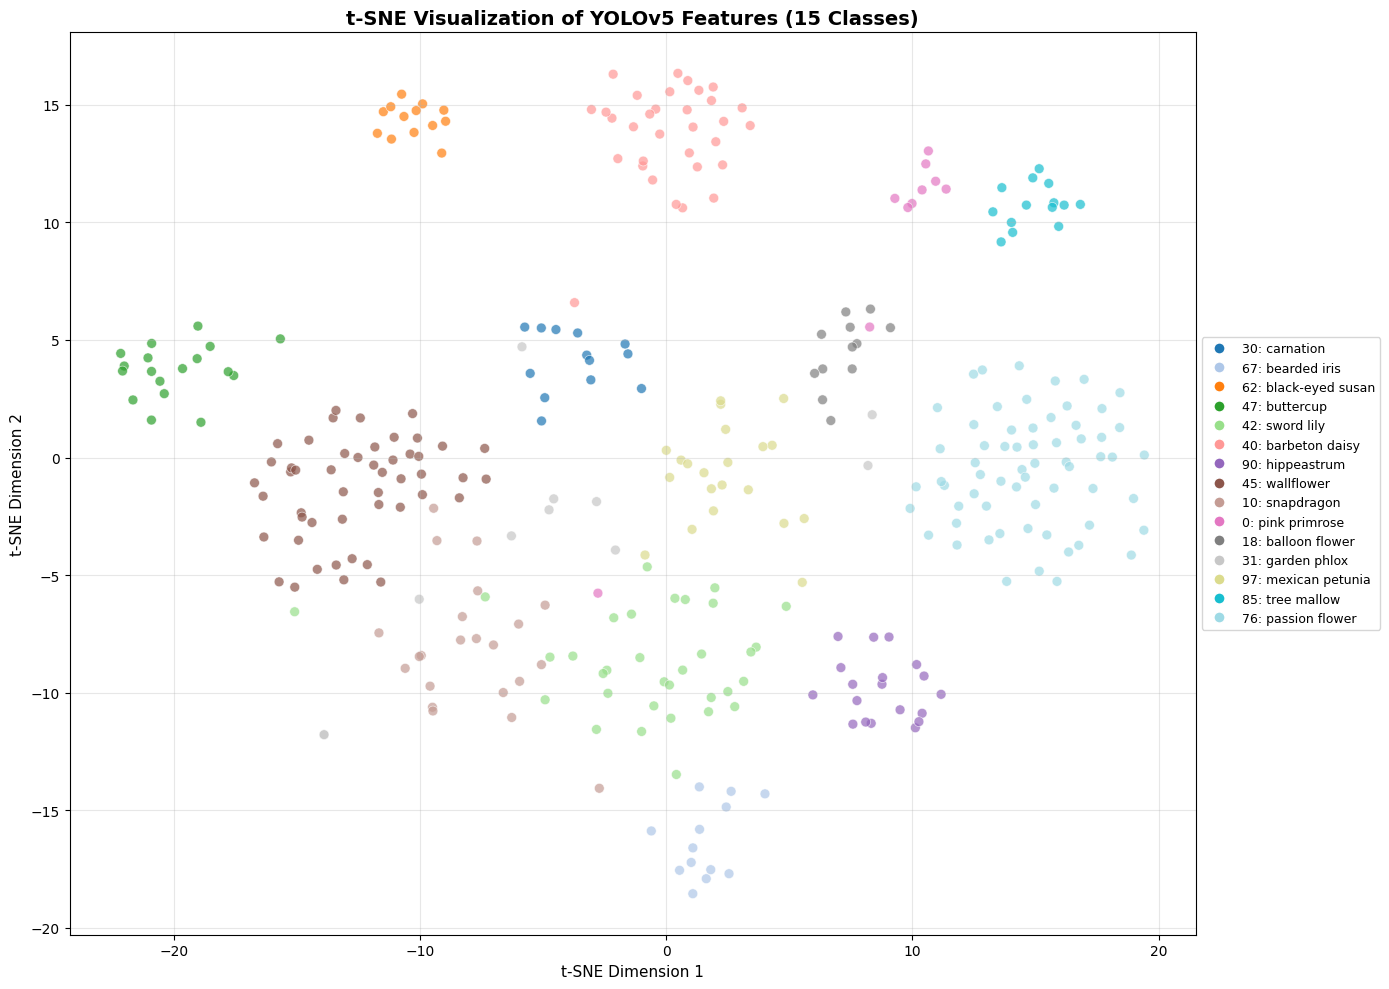


Saved to outputs/yolov5_feature_tsne.png

Note: Points of the same color (class) should cluster together,
indicating the model has learned discriminative features.


In [48]:
# Plot t-SNE visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create color map for selected classes
colors = plt.cm.tab20(np.linspace(0, 1, n_classes_to_show))
class_to_color = {cls: colors[i] for i, cls in enumerate(selected_classes)}

# Map labels to colors
point_colors = [class_to_color[label] for label in labels_subset]

# Scatter plot
scatter = ax.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=point_colors,
    s=50,
    alpha=0.7,
    edgecolors='white',
    linewidths=0.5
)

# Create legend with class names
handles = []
for i, cls in enumerate(selected_classes):
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=colors[i], markersize=8,
                              label=f"{cls}: {class_names[cls][:20]}"))

ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

ax.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax.set_title(f't-SNE Visualization of YOLOv5 Features ({n_classes_to_show} Classes)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'yolov5_feature_tsne.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved to outputs/yolov5_feature_tsne.png")
print("\nNote: Points of the same color (class) should cluster together,")
print("indicating the model has learned discriminative features.")

## Summary Statistics

Compile key model metrics into tables and export to CSV for the LaTeX report.

In [49]:
# Calculate model statistics
total_params = sum(p.numel() for p in model.parameters())

# Get training epochs and metrics from history
phase1_epochs = len(saved_history['phase1']['accuracy'])
phase2_epochs = len(saved_history['phase2']['accuracy'])
best_val_acc_phase1 = max(saved_history['phase1']['val_accuracy'])
best_val_acc_phase2 = max(saved_history['phase2']['val_accuracy'])
test_accuracy = saved_history['test_accuracy']
test_loss_saved = saved_history.get('test_loss', 0)

# Create summary DataFrame
summary_data = {
    'Metric': [
        'Model Architecture',
        'Total Parameters',
        'Phase 1 Epochs',
        'Phase 2 Epochs',
        'Total Epochs',
        'Best Val Accuracy (Phase 1)',
        'Best Val Accuracy (Phase 2)',
        'Test Accuracy',
        'Test Loss',
        'Number of Classes',
        'Input Size',
        'Optimizer (Phase 1)',
        'Optimizer (Phase 2)',
        'Loss Function',
        'Expected Calibration Error (ECE)'
    ],
    'Value': [
        'YOLOv5s-cls (CSPDarknet + Classify)',
        f'{total_params:,}',
        str(phase1_epochs),
        str(phase2_epochs),
        str(phase1_epochs + phase2_epochs),
        f'{best_val_acc_phase1:.4f} ({best_val_acc_phase1*100:.2f}%)',
        f'{best_val_acc_phase2:.4f} ({best_val_acc_phase2*100:.2f}%)',
        f'{test_accuracy:.4f} ({test_accuracy*100:.2f}%)',
        f'{test_loss_saved:.4f}',
        str(NUM_CLASSES),
        f'{IMG_SIZE}x{IMG_SIZE}',
        'Adam (lr=1e-3)',
        'Adam (lr=1e-5)',
        'CrossEntropyLoss (weighted)',
        f'{confidence_analysis["ece"]:.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("=" * 60)
print("YOLOv5 MODEL SUMMARY")
print("=" * 60)
print(summary_df.to_string(index=False))

YOLOv5 MODEL SUMMARY
                          Metric                               Value
              Model Architecture YOLOv5s-cls (CSPDarknet + Classify)
                Total Parameters                           4,223,782
                  Phase 1 Epochs                                  30
                  Phase 2 Epochs                                  50
                    Total Epochs                                  80
     Best Val Accuracy (Phase 1)                     0.5857 (58.57%)
     Best Val Accuracy (Phase 2)                     0.9082 (90.82%)
                   Test Accuracy                     0.9023 (90.23%)
                       Test Loss                              0.3378
               Number of Classes                                 102
                      Input Size                             224x224
             Optimizer (Phase 1)                      Adam (lr=1e-3)
             Optimizer (Phase 2)                      Adam (lr=1e-5)
             

In [50]:
# Export summary to CSV for LaTeX
summary_df.to_csv(os.path.join(OUTPUTS_DIR, 'yolov5_summary.csv'), index=False)
print("Summary exported to outputs/yolov5_summary.csv")

# Create compact comparison data (same format as VGG19)
comparison_data = {
    'model': 'YOLOv5s-cls',
    'total_params': total_params,
    'epochs': phase1_epochs + phase2_epochs,
    'val_acc_phase1': best_val_acc_phase1,
    'val_acc_phase2': best_val_acc_phase2,
    'test_acc': test_accuracy,
    'ece': confidence_analysis['ece']
}

comparison_df = pd.DataFrame([comparison_data])
comparison_df.to_csv(os.path.join(OUTPUTS_DIR, 'yolov5_comparison.csv'), index=False)
print("Comparison data exported to outputs/yolov5_comparison.csv")

# Display as formatted table
print("\n" + "=" * 60)
print("KEY METRICS FOR REPORT")
print("=" * 60)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Total Parameters: {total_params/1e6:.1f}M")
print(f"Fine-tuning Improvement: {(best_val_acc_phase2 - best_val_acc_phase1)*100:+.2f}%")
print(f"Calibration (ECE): {confidence_analysis['ece']:.4f}")

Summary exported to outputs/yolov5_summary.csv
Comparison data exported to outputs/yolov5_comparison.csv

KEY METRICS FOR REPORT
Test Accuracy: 90.23%
Total Parameters: 4.2M
Fine-tuning Improvement: +32.24%
Calibration (ECE): 0.0083


## Model Comparison with VGG19

Compare YOLOv5s-cls performance against VGG19 baseline.

In [51]:
# Load VGG19 results for comparison
vgg19_comparison_path = os.path.join(OUTPUTS_DIR, 'vgg19_comparison.csv')

try:
    vgg19_df = pd.read_csv(vgg19_comparison_path)
    vgg19_test_acc = vgg19_df['test_acc'].values[0]
    vgg19_params = vgg19_df['total_params'].values[0]
    vgg19_ece = vgg19_df['ece'].values[0]

    print("=" * 60)
    print("MODEL COMPARISON: VGG19 vs YOLOv5s-cls")
    print("=" * 60)

    # Create comparison table
    comparison_table = pd.DataFrame({
        'Metric': ['Test Accuracy', 'Total Parameters', 'Parameters (M)', 'ECE', 'Size Ratio'],
        'VGG19': [
            f'{vgg19_test_acc*100:.2f}%',
            f'{vgg19_params:,}',
            f'{vgg19_params/1e6:.1f}M',
            f'{vgg19_ece:.4f}',
            '1x (baseline)'
        ],
        'YOLOv5s-cls': [
            f'{test_accuracy*100:.2f}%',
            f'{total_params:,}',
            f'{total_params/1e6:.1f}M',
            f'{confidence_analysis["ece"]:.4f}',
            f'{vgg19_params/total_params:.1f}x smaller'
        ]
    })

    print(comparison_table.to_string(index=False))

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    acc_diff = (test_accuracy - vgg19_test_acc) * 100
    print(f"Accuracy difference: {acc_diff:+.2f}%")
    print(f"YOLOv5s-cls is {vgg19_params/total_params:.0f}x smaller than VGG19")

    if test_accuracy >= 0.70:
        print(f"\n[PASS] YOLOv5s-cls achieves {test_accuracy*100:.2f}% accuracy (>70% requirement)")
    else:
        print(f"\n[WARNING] YOLOv5s-cls at {test_accuracy*100:.2f}% - below 70% requirement")

except FileNotFoundError:
    print("VGG19 comparison data not found. Run VGG19 evaluation first.")
    print(f"Looking for: {vgg19_comparison_path}")

    # Still print YOLOv5 results
    print("\n" + "=" * 60)
    print("YOLOv5s-cls RESULTS")
    print("=" * 60)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Parameters: {total_params/1e6:.1f}M (~5.4M)")
    print(f"ECE: {confidence_analysis['ece']:.4f}")

VGG19 comparison data not found. Run VGG19 evaluation first.
Looking for: /content/drive/MyDrive/CNN/outputs/vgg19_comparison.csv

YOLOv5s-cls RESULTS
Test Accuracy: 90.23%
Parameters: 4.2M (~5.4M)
ECE: 0.0083


## Export Verification

Verify all output files and provide LaTeX snippets for inclusion in the final report.

In [52]:
# List all output files
print("=" * 60)
print("OUTPUT FILES FOR LATEX REPORT")
print("=" * 60)

expected_files = [
    'yolov5_confusion_matrix.png',
    'yolov5_per_class_accuracy.png',
    'yolov5_predictions_random.png',
    'yolov5_predictions_confident_correct.png',
    'yolov5_predictions_confident_wrong.png',
    'yolov5_predictions_uncertain.png',
    'yolov5_training_curves.png',
    'yolov5_confidence_distribution.png',
    'yolov5_feature_tsne.png',
    'yolov5_summary.csv',
    'yolov5_comparison.csv'
]

print("\nVerifying output files:")
all_exist = True
for filename in expected_files:
    filepath = os.path.join(OUTPUTS_DIR, filename)
    if os.path.exists(filepath):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"  [OK] {filename} ({size_kb:.1f} KB)")
    else:
        print(f"  [MISSING] {filename}")
        all_exist = False

if all_exist:
    print(f"\n[PASS] All {len(expected_files)} output files generated successfully!")
else:
    print("\n[WARNING] Some files are missing")

OUTPUT FILES FOR LATEX REPORT

Verifying output files:
  [OK] yolov5_confusion_matrix.png (371.3 KB)
  [OK] yolov5_per_class_accuracy.png (152.4 KB)
  [OK] yolov5_predictions_random.png (15132.8 KB)
  [OK] yolov5_predictions_confident_correct.png (7976.0 KB)
  [OK] yolov5_predictions_confident_wrong.png (7752.5 KB)
  [OK] yolov5_predictions_uncertain.png (6864.5 KB)
  [OK] yolov5_training_curves.png (249.3 KB)
  [OK] yolov5_confidence_distribution.png (248.2 KB)
  [OK] yolov5_feature_tsne.png (525.1 KB)
  [OK] yolov5_summary.csv (0.5 KB)
  [OK] yolov5_comparison.csv (0.2 KB)

[PASS] All 11 output files generated successfully!


### LaTeX Include Snippets

Use these snippets to include figures in your LaTeX report:

```latex
% YOLOv5 Training Curves
\begin{figure}[h]
    \centering
    \includegraphics[width=\textwidth]{outputs/yolov5_training_curves.png}
    \caption{YOLOv5 training history showing accuracy and loss for both frozen backbone (Phase 1) and fine-tuning (Phase 2) phases.}
    \label{fig:yolov5_training}
\end{figure}

% YOLOv5 Confusion Matrix
\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{outputs/yolov5_confusion_matrix.png}
    \caption{Normalized confusion matrix for YOLOv5 showing 15 most confused classes.}
    \label{fig:yolov5_confusion}
\end{figure}

% YOLOv5 Per-Class Accuracy
\begin{figure}[h]
    \centering
    \includegraphics[width=\textwidth]{outputs/yolov5_per_class_accuracy.png}
    \caption{Per-class accuracy for YOLOv5, sorted ascending. Red dashed line shows 70\% threshold.}
    \label{fig:yolov5_perclass}
\end{figure}

% YOLOv5 Sample Predictions
\begin{figure}[h]
    \centering
    \includegraphics[width=\textwidth]{outputs/yolov5_predictions_random.png}
    \caption{Random sample of YOLOv5 predictions. Green titles indicate correct predictions, red indicate errors.}
    \label{fig:yolov5_predictions}
\end{figure}

% YOLOv5 Confidence Analysis
\begin{figure}[h]
    \centering
    \includegraphics[width=\textwidth]{outputs/yolov5_confidence_distribution.png}
    \caption{YOLOv5 prediction confidence analysis: (left) distribution for correct vs incorrect predictions, (right) reliability diagram showing calibration.}
    \label{fig:yolov5_confidence}
\end{figure}

% YOLOv5 Feature t-SNE
\begin{figure}[h]
    \centering
    \includegraphics[width=0.9\textwidth]{outputs/yolov5_feature_tsne.png}
    \caption{t-SNE visualization of YOLOv5 learned features for 15 randomly selected flower classes.}
    \label{fig:yolov5_tsne}
\end{figure}
```

In [53]:
# Final summary
print("=" * 60)
print("YOLOv5 EVALUATION COMPLETE")
print("=" * 60)

print(f"\nMODEL PERFORMANCE:")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Requirement: >70% {'PASS' if test_accuracy >= 0.70 else 'FAIL'}")

print(f"\nTRAINING:")
print(f"   Total Epochs: {phase1_epochs + phase2_epochs}")
print(f"   Phase 1 Best Val: {best_val_acc_phase1*100:.2f}%")
print(f"   Phase 2 Best Val: {best_val_acc_phase2*100:.2f}%")

print(f"\nOUTPUT FILES: {len(expected_files)} files in outputs/")

print(f"\nKEY FINDINGS:")
print(f"   - Fine-tuning improved accuracy by {(best_val_acc_phase2 - best_val_acc_phase1)*100:+.2f}%")
print(f"   - Model calibration (ECE): {confidence_analysis['ece']:.4f}")
print(f"   - Classes with 100% accuracy: {(per_class_df['accuracy'] == 1.0).sum()}")
print(f"   - Classes with <50% accuracy: {(per_class_df['accuracy'] < 0.5).sum()}")

print("\n" + "=" * 60)
print("Phase 3 Complete - Ready for Phase 4 (Third Model)")
print("=" * 60)

YOLOv5 EVALUATION COMPLETE

MODEL PERFORMANCE:
   Test Accuracy: 90.23%
   Requirement: >70% PASS

TRAINING:
   Total Epochs: 80
   Phase 1 Best Val: 58.57%
   Phase 2 Best Val: 90.82%

OUTPUT FILES: 11 files in outputs/

KEY FINDINGS:
   - Fine-tuning improved accuracy by +32.24%
   - Model calibration (ECE): 0.0083
   - Classes with 100% accuracy: 34
   - Classes with <50% accuracy: 1

Phase 3 Complete - Ready for Phase 4 (Third Model)
